In [1]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import datetime as dt
from pivottablejs import pivot_ui
from IPython.display import HTML
import seaborn as sns
import rpy2
import pickle
import matplotlib as mp
from IPython.display import display
from PIL import Image

#import qgrid
#import ipywidgets as widgets

In [2]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [3]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [4]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [5]:
#stock_fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")
stock_fundamentals = market_data

In [6]:
market_data

beta currentRatio debtToEquity dividendRate dividendYield  \
PG    0.442647        0.681         73.6         3.65        0.0238   
NBHC  0.889215          NaN          NaN         0.92        0.0239   
ENTA  0.599509        8.629        5.446          NaN           NaN   
UDR   0.743627        0.107      121.819         1.52        0.0312   
SMTC  1.532843        3.912       26.055          NaN           NaN   
...        ...          ...          ...          ...           ...   
ACIW     error        error        error        error         error   
PFE   0.708257        1.386       44.072          1.6        0.0299   
VCR        NaN        error        error          NaN           NaN   
ARCB  1.578039        1.163       39.609         0.48        0.0056   
GME  -0.985027        2.067       42.531          NaN           NaN   

     earningsGrowth       ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
PG            0.051  21462999040       0.26957  22.319181  10515874816  ...   
NBHC         -0.302          NaN           0.0   14.79845          NaN  ...   
ENTA            NaN   -124440000      -1.33837   -7.81262    -46898876  ...   
UDR           4.743    804448000       0.59075  165.77777    827238016  ...   
SMTC          1.253    175896000       0.23742  18.732483    161634624  ...   
...             ...          ...           ...        ...          ...  ...   
ACIW          error        error         error      error        error  ...   
PFE           0.591  37115998208       0.40154   1.009058  34285750272  ...   
VCR           error        error         error        NaN        error  ...   
ARCB           2.08    468940992       0.10454    6.69856    122347504  ...   
GME             NaN   -343400000      -0.05618 -33.836586   -572687488  ...   

     revenuePerShare              sector sharesOutstanding shortRatio  \
PG            32.886  Consumer Defensive        2419950080       2.08   
NBHC           9.368  Financial Services          30297900       2.85   
ENTA           4.593          Healthcare          20324800       6.39   
UDR            4.455         Real Estate         309185984       5.38   
SMTC          11.457          Technology          64436800       2.94   
...              ...                 ...               ...        ...   
ACIW           error               error             error      error   
PFE           16.479          Healthcare        5610899968       2.23   
VCR            error               error             error      error   
ARCB         177.408         Industrials          24484200       3.79   
GME           81.416   Consumer Cyclical          76129000        5.7   

     totalAssets    totalCash totalCashPerShare    totalDebt totalRevenue  \
PG           NaN   8526000128             3.554  33668999168  79617998848   
NBHC         NaN    786385024            26.331     64249000    286185984   
ENTA         NaN    259052000            12.618     20933000     92979000   
UDR          NaN     11383000             0.036   5670699008   1361728000   
SMTC         NaN    290183008             4.527    192230000    740857984   
...          ...          ...               ...          ...          ...   
ACIW       error        error             error        error        error   
PFE          NaN  23901999104              4.26  36441001984  92432998400   
VCR   6015592448        error             error        error        error   
ARCB         NaN    101132000             4.131    389422016   4485927936   
GME          NaN   1035000000            13.665    617000000   6112300032   

     trailingPE  
PG    25.941154  
NBHC  12.120635  
ENTA      error  
UDR   248.66664  
SMTC   36.33107  
...         ...  
ACIW      error  
PFE   12.255329  
VCR       error  
ARCB   8.079044  
GME       error  

[1520 rows x 36 columns]

In [7]:
#print(stock_fundamentals)

In [8]:

import warnings
warnings.filterwarnings("ignore")

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)


In [9]:
#stock_fundamentals[stock_fundamentals.set_index(stock_fundamentals.iloc[:, 0]).index=='VOX']


In [10]:
#prices[prices['Symbol']=='VOX'].set_index('Date')

In [11]:
#plt.plot(prices[prices['Symbol']=='VOX'].set_index('Date')['Adj Close'])

In [12]:
#screener = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Screener")
screener = screener_sorted

In [13]:
#screener.set_index('Symbol').loc['BA']

In [14]:
#fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")
#fundamentals.set_index(fundamentals.columns[0],inplace=True)
fundamentals = stock_fundamentals

In [15]:
"""
stock_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500")
stock_indexes.drop(stock_indexes.columns[0], axis=1, inplace=True)
stock_indexes.set_index(stock_indexes.columns[0],inplace=True)
stock_indexes
"""
stock_indexes = sp1500_index_df

In [16]:
"""
spdr_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="spdr_indexes")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
spdr_indexes.set_index(spdr_indexes.columns[0],inplace=True)
spdr_indexes.columns=['Symbol']
spdr_indexes
"""
spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
spdr_indexes

Symbol
SP1500   SPTM
SP500     SPY
SP600     SLY
SP400    MDYG

In [17]:
"""
vanguard_sectors = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="vanguard_sectors")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
vanguard_sectors.set_index(vanguard_sectors.columns[0],inplace=True)
vanguard_sectors.columns=['Symbol']
vanguard_sectors
"""
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']
vanguard_sectors

Symbol
Communication Services ETF    VOX
Consumer Discretionary ETF    VCR
Consumer Staples ETF          VDC
Energy ETF                    VDE
Financials ETF                VFH
Health Care ETF               VHT
Industrials ETF               VIS
Information Technology ETF    VGT
Materials ETF                 VAW
Real Estate ETF               VNQ
Utilities ETF                 VPU

In [18]:
#[*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]

In [19]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [20]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
display(sector_performance_Q_smoothed_return)
display(sector_performance_return)

SP1500     SP500     SP600     SP400  \
2017-02-13       NaN       NaN       NaN       NaN   
2017-02-14       NaN       NaN       NaN       NaN   
2017-02-15       NaN       NaN       NaN       NaN   
2017-02-16       NaN       NaN       NaN       NaN   
2017-02-17       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...   
2022-06-06 -0.000133 -0.000158 -0.000068  0.000037   
2022-06-07  0.000130  0.000115  0.000059  0.000266   
2022-06-08 -0.000482 -0.000483 -0.000553 -0.000545   
2022-06-09 -0.000781 -0.000789 -0.000847 -0.000876   
2022-06-10 -0.001037 -0.001048 -0.001047 -0.001140   

            Communication Services ETF  Consumer Discretionary ETF  \
2017-02-13                         NaN                         NaN   
2017-02-14                         NaN                         NaN   
2017-02-15                         NaN                         NaN   
2017-02-16                         NaN                         NaN   
2017-02-17                         NaN                         NaN   
...                                ...                         ...   
2022-06-06                   -0.001031                   -0.000514   
2022-06-07                   -0.000944                   -0.000605   
2022-06-08                   -0.001474                   -0.001191   
2022-06-09                   -0.001803                   -0.001638   
2022-06-10                   -0.001934                   -0.001995   

            Consumer Staples ETF  Energy ETF  Financials ETF  Health Care ETF  \
2017-02-13                   NaN         NaN             NaN              NaN   
2017-02-14                   NaN         NaN             NaN              NaN   
2017-02-15                   NaN         NaN             NaN              NaN   
2017-02-16                   NaN         NaN             NaN              NaN   
2017-02-17                   NaN         NaN             NaN              NaN   
...                          ...         ...             ...              ...   
2022-06-06             -0.000083    0.002817       -0.000181        -0.000163   
2022-06-07              0.000391    0.003171       -0.000001         0.000366   
2022-06-08              0.000076    0.003582       -0.000862        -0.000078   
2022-06-09             -0.000038    0.002757       -0.001151        -0.000439   
2022-06-10              0.000070    0.002643       -0.001614        -0.000529   

            Industrials ETF  Information Technology ETF  Materials ETF  \
2017-02-13              NaN                         NaN            NaN   
2017-02-14              NaN                         NaN            NaN   
2017-02-15              NaN                         NaN            NaN   
2017-02-16              NaN                         NaN            NaN   
2017-02-17              NaN                         NaN            NaN   
...                     ...                         ...            ...   
2022-06-06        -0.000165                   -0.000374       0.001356   
2022-06-07         0.000084                   -0.000085       0.001630   
2022-06-08        -0.000548                   -0.000933       0.000769   
2022-06-09        -0.000833                   -0.001105       0.000275   
2022-06-10        -0.001207                   -0.001398      -0.000078   

            Real Estate ETF  Utilities ETF  
2017-02-13              NaN            NaN  
2017-02-14              NaN            NaN  
2017-02-15              NaN            NaN  
2017-02-16              NaN            NaN  
2017-02-17              NaN            NaN  
...                     ...            ...  
2022-06-06        -0.000703       0.000713  
2022-06-07        -0.000408       0.001018  
2022-06-08        -0.001018       0.000828  
2022-06-09        -0.001434       0.000351  
2022-06-10        -0.001660       0.000286  

[1342 rows x 15 columns]

SP1500     SP500     SP600     SP400  \
2017-03-31       NaN       NaN       NaN       NaN   
2017-06-30  0.030375  0.030708  0.018327  0.031752   
2017-09-30  0.044807  0.045666  0.064962  0.035020   
2017-12-31  0.066880  0.069917  0.038747  0.074139   
2018-03-31 -0.021321 -0.024130 -0.011631 -0.003978   
2018-06-30  0.052094  0.047568  0.106722  0.045520   
2018-09-30  0.070536  0.078236  0.032842  0.032902   
2018-12-31 -0.142834 -0.137319 -0.193040 -0.172165   
2019-03-31  0.151853  0.144236  0.124660  0.157497   
2019-06-30  0.039106  0.040369  0.010843  0.030815   
2019-09-30  0.006291  0.011423 -0.004200 -0.009122   
2019-12-31  0.090490  0.089876  0.082573  0.066590   
2020-03-31 -0.205302 -0.194477 -0.328050 -0.247693   
2020-06-30  0.206715  0.201618  0.223617  0.259149   
2020-09-30  0.086119  0.090383  0.032878  0.068091   
2020-12-31  0.132216  0.121185  0.312278  0.211458   
2021-03-31  0.070761  0.063518  0.184526  0.084662   
2021-06-30  0.080495  0.083593  0.043034  0.033635   
2021-09-30  0.000378  0.002523 -0.030694 -0.024123   
2021-12-31  0.103038  0.106772  0.049293  0.077726   
2022-03-31 -0.049102 -0.049099 -0.058344 -0.089783   
2022-06-10 -0.133501 -0.136923 -0.094221 -0.126263   

            Communication Services ETF  Consumer Discretionary ETF  \
2017-03-31                         NaN                         NaN   
2017-06-30                   -0.024136                    0.028386   
2017-09-30                    0.015498                    0.014521   
2017-12-31                    0.000763                    0.097848   
2018-03-31                   -0.085669                   -0.001942   
2018-06-30                    0.035862                    0.088528   
2018-09-30                    0.023115                    0.066008   
2018-12-31                   -0.143117                   -0.162070   
2019-03-31                    0.139541                    0.157197   
2019-06-30                    0.035928                    0.040127   
2019-09-30                   -0.002023                    0.002509   
2019-12-31                    0.086727                    0.056223   
2020-03-31                   -0.187109                   -0.231167   
2020-06-30                    0.224230                    0.379795   
2020-09-30                    0.097573                    0.192380   
2020-12-31                    0.182130                    0.172875   
2021-03-31                    0.083288                    0.073815   
2021-06-30                    0.108092                    0.064435   
2021-09-30                   -0.021207                   -0.012866   
2021-12-31                   -0.037011                    0.099010   
2022-03-31                   -0.114414                   -0.103975   
2022-06-10                   -0.186172                   -0.213144   

            Consumer Staples ETF  Energy ETF  Financials ETF  Health Care ETF  \
2017-03-31                   NaN         NaN             NaN              NaN   
2017-06-30              0.010040   -0.078709        0.038955         0.072895   
2017-09-30             -0.012346    0.069612        0.052789         0.040565   
2017-12-31              0.059268    0.073946        0.073683         0.018576   
2018-03-31             -0.073521   -0.078807       -0.015065        -0.020049   
2018-06-30              0.006353    0.150528       -0.011331         0.055259   
2018-09-30              0.050064    0.021911        0.031675         0.137698   
2018-12-31             -0.055862   -0.267451       -0.138848        -0.108129   
2019-03-31              0.111156    0.178564        0.109942         0.081835   
2019-06-30              0.036556   -0.048754        0.067026         0.017469   
2019-09-30              0.056319   -0.075658        0.013235        -0.035439   
2019-12-31              0.036517    0.054552        0.096390         0.147851   
2020-03-31             -0.141472   -0.523877       -0.330709        -0.131539   
2020-06-30              0.

In [21]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    #print(s)
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

A = seasonal_indexes[si]
#B = seasonal_indexes[si]
display(seasonal_indexes[si].style.apply(b_g,cmap=cm))
#display(df)

#display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


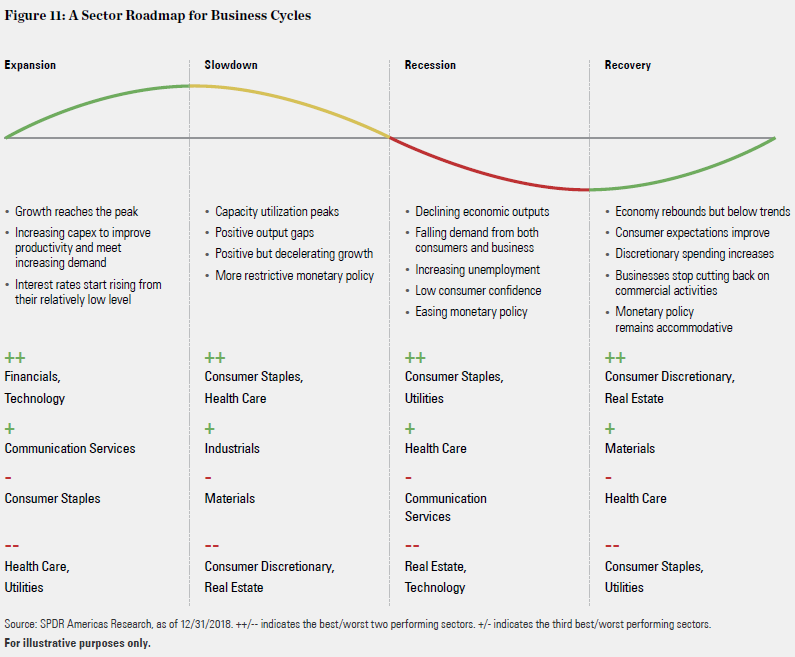

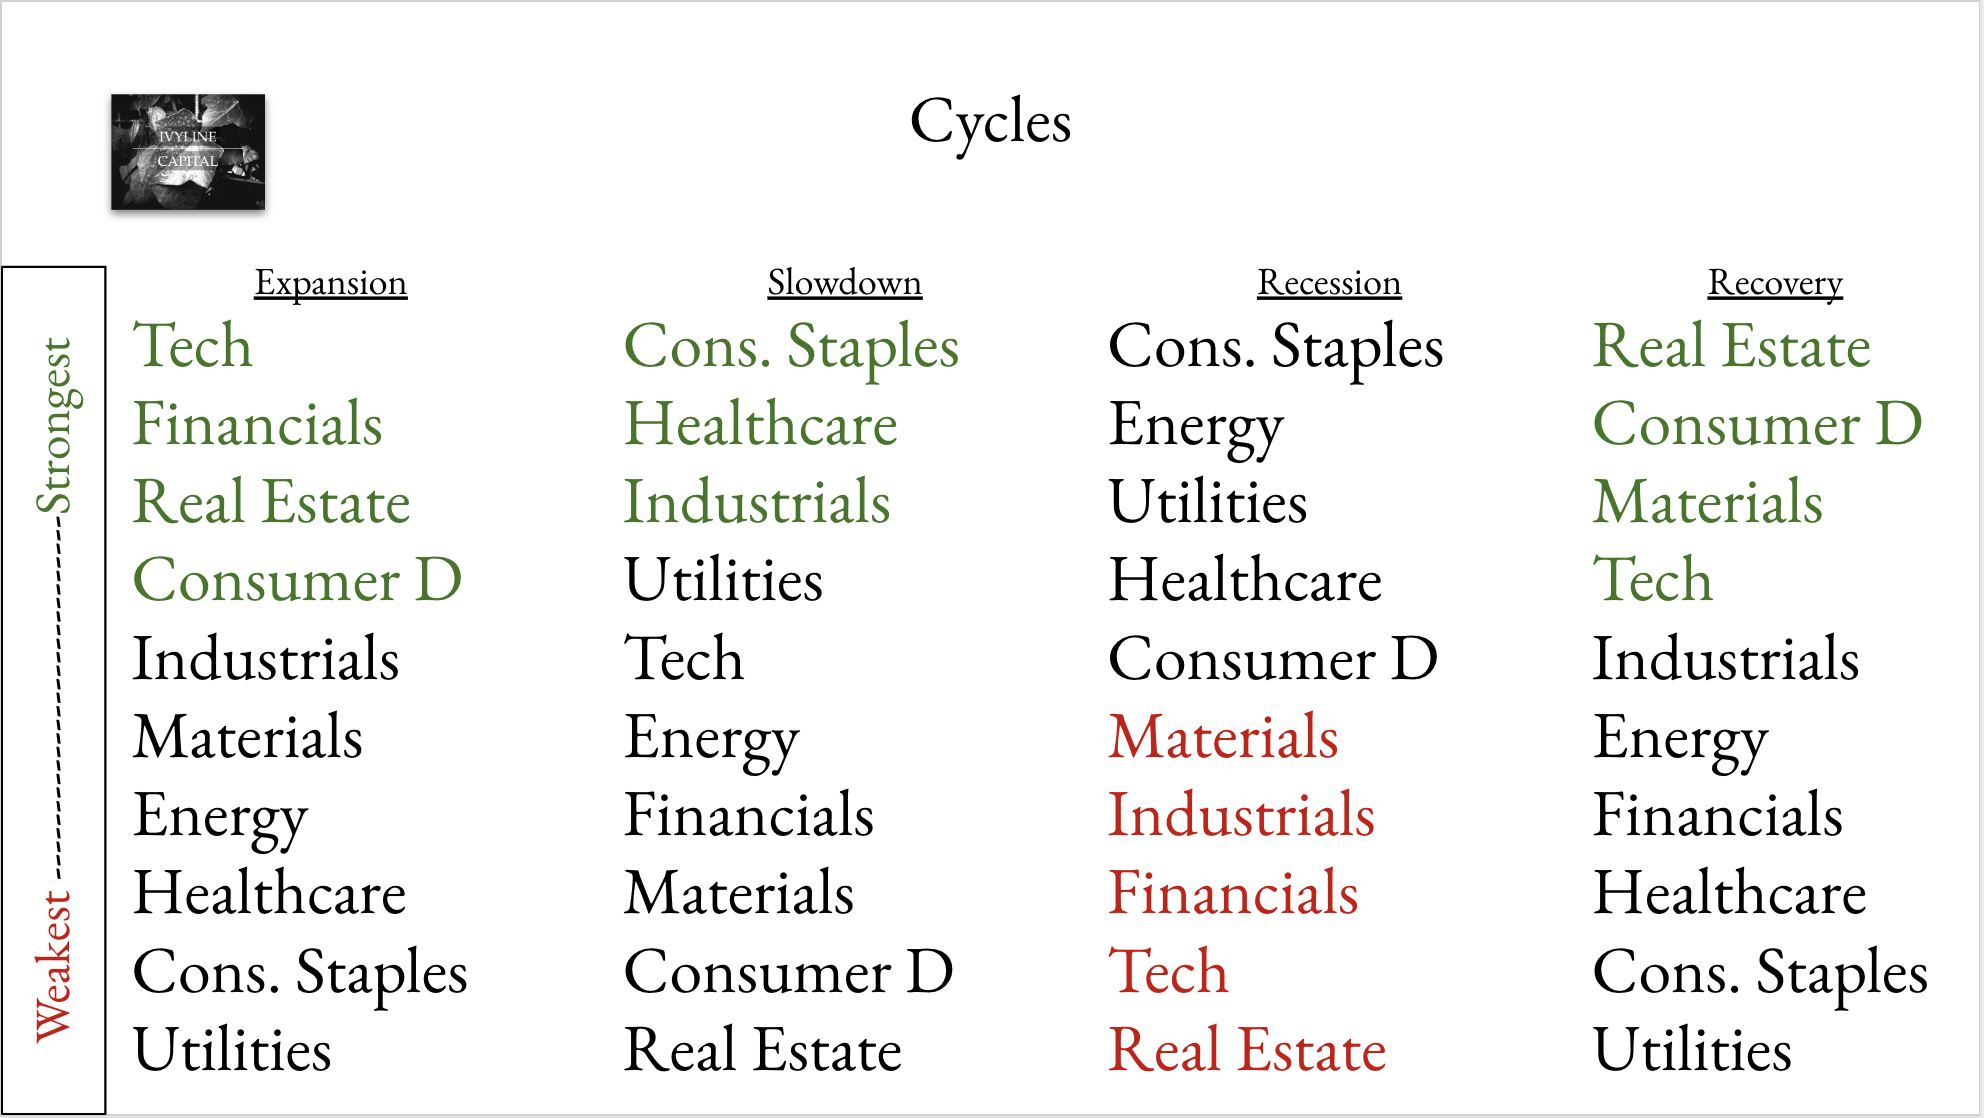

In [22]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

means


03-31     06-30     09-30     12-31
SP1500                     -0.010622  0.081757  0.041626  0.049958
SP500                      -0.011990  0.080771  0.045646  0.050086
SP600                      -0.017768  0.080509  0.019158  0.057970
SP400                      -0.019859  0.080174  0.020554  0.051549
Communication Services ETF -0.032872  0.075995  0.022591  0.017899
Consumer Discretionary ETF -0.021214  0.120254  0.052510  0.052777
Consumer Staples ETF       -0.018663  0.035480  0.034807  0.045915
Energy ETF                  0.055913  0.096281 -0.039735  0.042416
Financials ETF             -0.020711  0.061049  0.030176  0.065446
Health Care ETF            -0.017923  0.078706  0.041045  0.047467
Industrials ETF            -0.011020  0.058300  0.045427  0.039920
Information Technology ETF  0.006217  0.121831  0.068693  0.067531
Materials ETF              -0.026671  0.082827  0.027940  0.058669
Real Estate ETF            -0.026416  0.075756  0.019424  0.038472
Utilities ETF              -0.001263  0.026125  0.039218  0.042001

standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

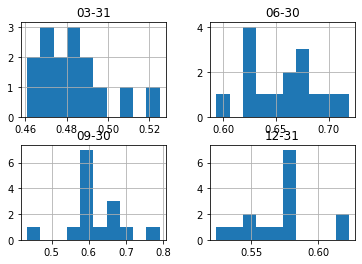

In [23]:
from scipy import stats as st
from scipy.stats import t

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))
#display(sector_performances_values)
#sector_performances

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')
#df.index = A.index
#sector_performances.style.background_gradient(cmap = cm,axis=1,)

display(df)

#calculate p-value
n=5
print("means")
display(seasonal_indexes[si])
print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)
def highlight_cells(val):
    color = 'yellow' if val <= .50 else 'green'
    #color = 'green' if val > .50 else ''
    return 'background-color: {}'.format(color)

display(p_values.style.applymap(highlight_cells))

p_values.hist()

#st.ttest_1samp(seasonal_indexes[si]/std_indexes[si],popmean=0,df=4-2)

#Ttest_1sampResult(statistic=0.36789006583267403, pvalue=0.714539654336473)

In [24]:
s

Utilities ETF Years Quarters
2017-03-31            NaN  2017    03-31
2017-06-30       0.022113  2017    06-30
2017-09-30       0.031518  2017    09-30
2017-12-31       0.000687  2017    12-31
2018-03-31      -0.033734  2018    03-31
2018-06-30       0.053422  2018    06-30
2018-09-30       0.019751  2018    09-30
2018-12-31       0.009925  2018    12-31
2019-03-31       0.103055  2019    03-31
2019-06-30       0.035855  2019    06-30
2019-09-30       0.090872  2019    09-30
2019-12-31       0.002011  2019    12-31
2020-03-31      -0.141270  2020    03-31
2020-06-30       0.024507  2020    06-30
2020-09-30       0.051209  2020    09-30
2020-12-31       0.073335  2020    12-31
2021-03-31       0.031042  2021    03-31
2021-06-30      -0.005272  2021    06-30
2021-09-30       0.002739  2021    09-30
2021-12-31       0.124048  2021    12-31
2022-03-31       0.034591  2022    03-31
2022-06-10      -0.038317  2022    06-10

In [55]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)



print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    #print(c)
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))
#display(sector_performances_values)
#sector_performances

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
#df.index = A.index
#sector_performances.style.background_gradient(cmap = cm,axis=1,)
display(df_sea_adj)
#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))    

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [27]:
seasonally_adjusted

SP1500     SP500     SP600     SP400  \
2017-03-31       NaN       NaN       NaN       NaN   
2017-06-30 -0.051382 -0.050063 -0.062182 -0.048422   
2017-09-30  0.003181  0.000019  0.045805  0.014467   
2017-12-31  0.016922  0.019831 -0.019223  0.022589   
2018-03-31 -0.010699 -0.012140  0.006137  0.015881   
2018-06-30 -0.029663 -0.033203  0.026213 -0.034654   
2018-09-30  0.028910  0.032590  0.013684  0.012348   
2018-12-31 -0.192792 -0.187405 -0.251011 -0.223715   
2019-03-31  0.162475  0.156226  0.142428  0.177356   
2019-06-30 -0.042651 -0.040402 -0.069666 -0.049360   
2019-09-30 -0.035335 -0.034223 -0.023358 -0.029676   
2019-12-31  0.040532  0.039790  0.024603  0.015040   
2020-03-31 -0.194680 -0.182486 -0.310282 -0.227834   
2020-06-30  0.124958  0.120846  0.143108  0.178975   
2020-09-30  0.044493  0.044737  0.013720  0.047537   
2020-12-31  0.082258  0.071099  0.254308  0.159908   
2021-03-31  0.081383  0.075508  0.202294  0.104521   
2021-06-30 -0.001262  0.002822 -0.037474 -0.046539   
2021-09-30 -0.041249 -0.043123 -0.049851 -0.044676   
2021-12-31  0.053080  0.056686 -0.008677  0.026177   
2022-03-31 -0.038479 -0.037108 -0.040576 -0.069924   
2022-06-10  0.064383  0.063601  0.063392  0.063127   

            Communication Services ETF  Consumer Discretionary ETF  \
2017-03-31                         NaN                         NaN   
2017-06-30                   -0.100131                   -0.091868   
2017-09-30                   -0.007093                   -0.037990   
2017-12-31                   -0.017136                    0.045071   
2018-03-31                   -0.052796                    0.019273   
2018-06-30                   -0.040133                   -0.031726   
2018-09-30                    0.000523                    0.013497   
2018-12-31                   -0.161015                   -0.214847   
2019-03-31                    0.172414                    0.178411   
2019-06-30                   -0.040067                   -0.080127   
2019-09-30                   -0.024614                   -0.050001   
2019-12-31                    0.068829                    0.003446   
2020-03-31                   -0.154237                   -0.209953   
2020-06-30                    0.148234                    0.259541   
2020-09-30                    0.074982                    0.139870   
2020-12-31                    0.164231                    0.120098   
2021-03-31                    0.116161                    0.095029   
2021-06-30                    0.032097                   -0.055819   
2021-09-30                   -0.043798                   -0.065376   
2021-12-31                   -0.054909                    0.046232   
2022-03-31                   -0.081542                   -0.082760   
2022-06-10                    0.059812                    0.095053   

            Consumer Staples ETF  Energy ETF  Financials ETF  Health Care ETF  \
2017-03-31                   NaN         NaN             NaN              NaN   
2017-06-30             -0.025440   -0.174990       -0.022094        -0.005811   
2017-09-30             -0.047152    0.109346        0.022612        -0.000480   
2017-12-31              0.013353    0.031530        0.008236        -0.028891   
2018-03-31             -0.054858   -0.134719        0.005646        -0.002126   
2018-06-30             -0.029127    0.054247       -0.072380        -0.023447   
2018-09-30              0.015257    0.061646        0.001499         0.096653   
2018-12-31             -0.101777   -0.309867       -0.204295        -0.155596   
2019-03-31              0.129819    0.122651        0.130653         0.099759   
2019-06-30              0.001076   -0.145035        0.005977        -0.061237   
2019-09-30              0.021512   -0.035923       -0.016941        -0.076484   
2019-12-31             -0.009397    0.012136        0.030943         0.100384   
2020-03-31             -0.122809   -0.579790       -0.309998        -0.113615   
2020-06-30              0.

In [28]:
vanguard_sectors

Symbol
Communication Services ETF    VOX
Consumer Discretionary ETF    VCR
Consumer Staples ETF          VDC
Energy ETF                    VDE
Financials ETF                VFH
Health Care ETF               VHT
Industrials ETF               VIS
Information Technology ETF    VGT
Materials ETF                 VAW
Real Estate ETF               VNQ
Utilities ETF                 VPU

In [29]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    #print(v)
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
    #print([v,)
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    

Symbol  risk_trend_factor                      Sector
3     VDE           3.378308                  Energy ETF
10    VPU          -0.903846               Utilities ETF
2     VDC          -1.815370        Consumer Staples ETF
8     VAW          -2.983225               Materials ETF
9     VNQ          -3.885849             Real Estate ETF
5     VHT          -3.947143             Health Care ETF
6     VIS          -5.096830             Industrials ETF
1     VCR          -5.274843  Consumer Discretionary ETF
4     VFH          -5.669687              Financials ETF
7     VGT          -6.117689  Information Technology ETF
0     VOX          -9.183162  Communication Services ETF

Rolling Quarterly Mean Return


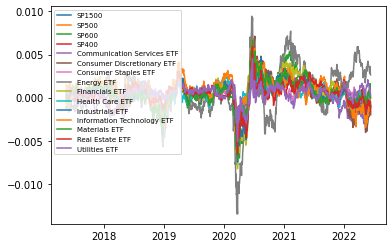

In [30]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

In [31]:
sector_performance_return

SP1500     SP500     SP600     SP400  \
2017-03-31       NaN       NaN       NaN       NaN   
2017-06-30  0.030375  0.030708  0.018327  0.031752   
2017-09-30  0.044807  0.045666  0.064962  0.035020   
2017-12-31  0.066880  0.069917  0.038747  0.074139   
2018-03-31 -0.021321 -0.024130 -0.011631 -0.003978   
2018-06-30  0.052094  0.047568  0.106722  0.045520   
2018-09-30  0.070536  0.078236  0.032842  0.032902   
2018-12-31 -0.142834 -0.137319 -0.193040 -0.172165   
2019-03-31  0.151853  0.144236  0.124660  0.157497   
2019-06-30  0.039106  0.040369  0.010843  0.030815   
2019-09-30  0.006291  0.011423 -0.004200 -0.009122   
2019-12-31  0.090490  0.089876  0.082573  0.066590   
2020-03-31 -0.205302 -0.194477 -0.328050 -0.247693   
2020-06-30  0.206715  0.201618  0.223617  0.259149   
2020-09-30  0.086119  0.090383  0.032878  0.068091   
2020-12-31  0.132216  0.121185  0.312278  0.211458   
2021-03-31  0.070761  0.063518  0.184526  0.084662   
2021-06-30  0.080495  0.083593  0.043034  0.033635   
2021-09-30  0.000378  0.002523 -0.030694 -0.024123   
2021-12-31  0.103038  0.106772  0.049293  0.077726   
2022-03-31 -0.049102 -0.049099 -0.058344 -0.089783   
2022-06-10 -0.133501 -0.136923 -0.094221 -0.126263   

            Communication Services ETF  Consumer Discretionary ETF  \
2017-03-31                         NaN                         NaN   
2017-06-30                   -0.024136                    0.028386   
2017-09-30                    0.015498                    0.014521   
2017-12-31                    0.000763                    0.097848   
2018-03-31                   -0.085669                   -0.001942   
2018-06-30                    0.035862                    0.088528   
2018-09-30                    0.023115                    0.066008   
2018-12-31                   -0.143117                   -0.162070   
2019-03-31                    0.139541                    0.157197   
2019-06-30                    0.035928                    0.040127   
2019-09-30                   -0.002023                    0.002509   
2019-12-31                    0.086727                    0.056223   
2020-03-31                   -0.187109                   -0.231167   
2020-06-30                    0.224230                    0.379795   
2020-09-30                    0.097573                    0.192380   
2020-12-31                    0.182130                    0.172875   
2021-03-31                    0.083288                    0.073815   
2021-06-30                    0.108092                    0.064435   
2021-09-30                   -0.021207                   -0.012866   
2021-12-31                   -0.037011                    0.099010   
2022-03-31                   -0.114414                   -0.103975   
2022-06-10                   -0.186172                   -0.213144   

            Consumer Staples ETF  Energy ETF  Financials ETF  Health Care ETF  \
2017-03-31                   NaN         NaN             NaN              NaN   
2017-06-30              0.010040   -0.078709        0.038955         0.072895   
2017-09-30             -0.012346    0.069612        0.052789         0.040565   
2017-12-31              0.059268    0.073946        0.073683         0.018576   
2018-03-31             -0.073521   -0.078807       -0.015065        -0.020049   
2018-06-30              0.006353    0.150528       -0.011331         0.055259   
2018-09-30              0.050064    0.021911        0.031675         0.137698   
2018-12-31             -0.055862   -0.267451       -0.138848        -0.108129   
2019-03-31              0.111156    0.178564        0.109942         0.081835   
2019-06-30              0.036556   -0.048754        0.067026         0.017469   
2019-09-30              0.056319   -0.075658        0.013235        -0.035439   
2019-12-31              0.036517    0.054552        0.096390         0.147851   
2020-03-31             -0.141472   -0.523877       -0.330709        -0.131539   
2020-06-30              0.

Quarterly Returns


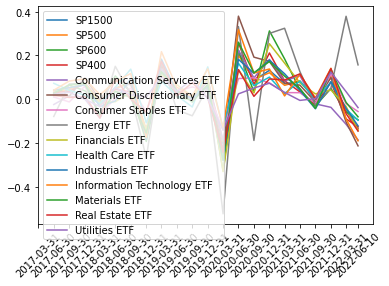

In [32]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [33]:
sector_performance_return.iloc[-1].sort_values(ascending=False).index

Index(['Energy ETF', 'Utilities ETF', 'Consumer Staples ETF', 'Materials ETF',
       'SP600', 'Health Care ETF', 'Industrials ETF', 'SP400', 'SP1500',
       'SP500', 'Financials ETF', 'Real Estate ETF',
       'Communication Services ETF', 'Information Technology ETF',
       'Consumer Discretionary ETF'],
      dtype='object')

In [34]:
sector_performance_return

SP1500     SP500     SP600     SP400  \
2017-03-31       NaN       NaN       NaN       NaN   
2017-06-30  0.030375  0.030708  0.018327  0.031752   
2017-09-30  0.044807  0.045666  0.064962  0.035020   
2017-12-31  0.066880  0.069917  0.038747  0.074139   
2018-03-31 -0.021321 -0.024130 -0.011631 -0.003978   
2018-06-30  0.052094  0.047568  0.106722  0.045520   
2018-09-30  0.070536  0.078236  0.032842  0.032902   
2018-12-31 -0.142834 -0.137319 -0.193040 -0.172165   
2019-03-31  0.151853  0.144236  0.124660  0.157497   
2019-06-30  0.039106  0.040369  0.010843  0.030815   
2019-09-30  0.006291  0.011423 -0.004200 -0.009122   
2019-12-31  0.090490  0.089876  0.082573  0.066590   
2020-03-31 -0.205302 -0.194477 -0.328050 -0.247693   
2020-06-30  0.206715  0.201618  0.223617  0.259149   
2020-09-30  0.086119  0.090383  0.032878  0.068091   
2020-12-31  0.132216  0.121185  0.312278  0.211458   
2021-03-31  0.070761  0.063518  0.184526  0.084662   
2021-06-30  0.080495  0.083593  0.043034  0.033635   
2021-09-30  0.000378  0.002523 -0.030694 -0.024123   
2021-12-31  0.103038  0.106772  0.049293  0.077726   
2022-03-31 -0.049102 -0.049099 -0.058344 -0.089783   
2022-06-10 -0.133501 -0.136923 -0.094221 -0.126263   

            Communication Services ETF  Consumer Discretionary ETF  \
2017-03-31                         NaN                         NaN   
2017-06-30                   -0.024136                    0.028386   
2017-09-30                    0.015498                    0.014521   
2017-12-31                    0.000763                    0.097848   
2018-03-31                   -0.085669                   -0.001942   
2018-06-30                    0.035862                    0.088528   
2018-09-30                    0.023115                    0.066008   
2018-12-31                   -0.143117                   -0.162070   
2019-03-31                    0.139541                    0.157197   
2019-06-30                    0.035928                    0.040127   
2019-09-30                   -0.002023                    0.002509   
2019-12-31                    0.086727                    0.056223   
2020-03-31                   -0.187109                   -0.231167   
2020-06-30                    0.224230                    0.379795   
2020-09-30                    0.097573                    0.192380   
2020-12-31                    0.182130                    0.172875   
2021-03-31                    0.083288                    0.073815   
2021-06-30                    0.108092                    0.064435   
2021-09-30                   -0.021207                   -0.012866   
2021-12-31                   -0.037011                    0.099010   
2022-03-31                   -0.114414                   -0.103975   
2022-06-10                   -0.186172                   -0.213144   

            Consumer Staples ETF  Energy ETF  Financials ETF  Health Care ETF  \
2017-03-31                   NaN         NaN             NaN              NaN   
2017-06-30              0.010040   -0.078709        0.038955         0.072895   
2017-09-30             -0.012346    0.069612        0.052789         0.040565   
2017-12-31              0.059268    0.073946        0.073683         0.018576   
2018-03-31             -0.073521   -0.078807       -0.015065        -0.020049   
2018-06-30              0.006353    0.150528       -0.011331         0.055259   
2018-09-30              0.050064    0.021911        0.031675         0.137698   
2018-12-31             -0.055862   -0.267451       -0.138848        -0.108129   
2019-03-31              0.111156    0.178564        0.109942         0.081835   
2019-06-30              0.036556   -0.048754        0.067026         0.017469   
2019-09-30              0.056319   -0.075658        0.013235        -0.035439   
2019-12-31              0.036517    0.054552        0.096390         0.147851   
2020-03-31             -0.141472   -0.523877       -0.330709        -0.131539   
2020-06-30              0.

In [35]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
sector_performance_return_pvt_heatmap

In [36]:
seasonal_indexes.index

Index(['SP1500', 'SP500', 'SP600', 'SP400', 'Communication Services ETF',
       'Consumer Discretionary ETF', 'Consumer Staples ETF', 'Energy ETF',
       'Financials ETF', 'Health Care ETF', 'Industrials ETF',
       'Information Technology ETF', 'Materials ETF', 'Real Estate ETF',
       'Utilities ETF'],
      dtype='object')

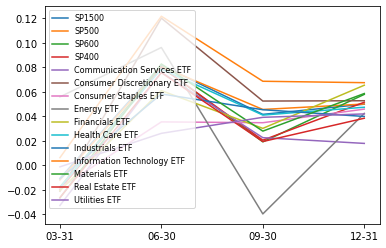

In [37]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [38]:
seasonal_indexes[seasonal_indexes.columns.difference(si)]

06-10
SP1500                     -0.133501
SP500                      -0.136923
SP600                      -0.094221
SP400                      -0.126263
Communication Services ETF -0.186172
Consumer Discretionary ETF -0.213144
Consumer Staples ETF       -0.056250
Energy ETF                  0.157138
Financials ETF             -0.144127
Health Care ETF            -0.096116
Industrials ETF            -0.121767
Information Technology ETF -0.190021
Materials ETF              -0.080392
Real Estate ETF            -0.145335
Utilities ETF              -0.038317

In [39]:
threshold = .9875

In [40]:
screener

max_2y      min_2y     std_2y     mean_2y      max_1y      min_1y  \
Symbol                                                                          
MTOR     36.299999       18.16   4.606631    26.98698   36.299999        20.5   
Y       862.869995  460.579987  89.563942   650.64594  862.869995  585.099976   
TVTY     32.889999       10.19   5.620871    22.92804   32.889999       21.25   
MCK     339.940002  139.759995  52.614213  207.774528  339.940002  184.429993   
ACC      65.220001       31.07   9.214313   45.950842   65.220001   46.720001   
...            ...         ...        ...         ...         ...         ...   
AMAT       missing     missing    missing     missing     missing     missing   
ANTM       missing     missing    missing     missing     missing     missing   
HAL        missing     missing    missing     missing     missing     missing   
NEM        missing     missing    missing     missing     missing     missing   
CAH        missing     missing    missing     missing     missing     missing   

           std_1y     mean_1y    latest_p 2yr_close_0pct  ...  \
Symbol                                                    ...   
MTOR     5.460747    27.86792   36.119999          12.11  ...   
Y       76.003139  705.076921  834.109985     451.859985  ...   
TVTY     3.298713      26.784   32.279999           2.68  ...   
MCK     48.520659  245.625375  313.339996     104.688698  ...   
ACC      5.555166   53.561347   64.769997       18.98494  ...   
...           ...         ...         ...            ...  ...   
AMAT      missing     missing     missing        missing  ...   
ANTM      missing     missing     missing        missing  ...   
HAL       missing     missing     missing        missing  ...   
NEM       missing     missing     missing        missing  ...   
CAH       missing     missing     missing        missing  ...   

            vol_30d_2yr   pct_1yr   pct_2yr MIN_Lookback_One_Year  \
Symbol                                                              
MTOR     20301256.12708  0.988608  0.990077                 32.93   
Y        1456858.698941  0.896461  0.928509            737.890015   
TVTY    14974563.993949  0.947594  0.973128                 27.85   
MCK     33946622.768533   0.82895   0.86712            204.660004   
ACC     20837020.877458  0.975675  0.986823             49.209999   
...                 ...       ...       ...                   ...   
AMAT            missing   missing   missing               missing   
ANTM            missing   missing   missing               missing   
HAL             missing   missing   missing               missing   
NEM             missing   missing   missing               missing   
CAH             missing   missing   missing               missing   

       MIN_Lookback_6_Months MIN_Lookback_2_Months MIN_Lookback_1_Months  \
Symbol                                                                     
MTOR                   32.93             36.240002             36.279999   
Y                 737.890015            862.869995            862.869995   
TVTY                   29.18             32.889999             32.889999   
MCK               233.740005            329.359985            339.940002   
ACC                55.619999             58.009998             65.019997   
...                      ...                   ...                   ...   
AMAT                 missing               missing               missing   
ANTM                 missing               missing               missing   
HAL                  missing               missing               missing   
NEM                  missing               missing               missing   
CAH                  missing               missing               missing   

       volume_factor       adf     hurst  
Symbol                                    
MTOR        1.167952  0.308552  0.433895  
Y           1.713893  0.389055  0.457411  
TVTY        0.975728  0.524133  0.449983  
MCK       

In [41]:
screener_good = screener[screener['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [42]:
risk_trend_threshold

3.186660672008169

In [43]:
stock_sectors = stock_fundamentals['sector']

In [44]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
temp

Symbol              Sector
0        PG  Consumer Defensive
1      NBHC  Financial Services
2      ENTA          Healthcare
3       UDR         Real Estate
4      SMTC          Technology
...     ...                 ...
1515   ACIW               error
1516    PFE          Healthcare
1517    VCR               error
1518   ARCB         Industrials
1519    GME   Consumer Cyclical

[1520 rows x 2 columns]

In [45]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened
#left join sector
risk_screened.merge(temp, on='Symbol', how='left')

Symbol      max_2y      min_2y     std_2y     mean_2y      max_1y  \
0    MTOR   36.299999       18.16   4.606631    26.98698   36.299999   
1       Y  862.869995  460.579987  89.563942   650.64594  862.869995   
2    TVTY   32.889999       10.19   5.620871    22.92804   32.889999   
3     MCK  339.940002  139.759995  52.614213  207.774528  339.940002   
4     ACC   65.220001       31.07   9.214313   45.950842   65.220001   
5     CVX  182.399994   65.160004  29.711143  105.228454  182.399994   
6     EQT       50.41       10.52   8.067941   20.832639       50.41   
7    LNTH   73.779999       10.52  15.093208    26.37563   73.779999   
8     SWX   95.620003        57.0   8.203573   67.857751   95.620003   
9     MPC  114.349998   26.559999  19.074529   55.904358  114.349998   
10   MUSA  262.579987  109.110001  35.616647  156.556014  262.579987   
11    SJI       35.32       18.24   4.548892   24.632769       35.32   
12    VDE  130.350006   36.619999  21.815405   71.425177  130.350006   
13    XOM      105.57   31.110001  17.530923    56.46274      105.57   
14    DVN   79.400002        7.73  18.689183   30.540565   79.400002   
15    MRO   33.240002        3.73    7.09796   12.982678   33.240002   
16    PBF   44.119999        4.06   7.061263     13.9418   44.119999   
17    APA   51.950001        7.45  10.056634   22.599485   51.950001   
18   CTRA   36.549999       14.28   4.380073    20.14794   36.549999   

        min_1y     std_1y     mean_1y    latest_p  ...   pct_1yr   pct_2yr  \
0         20.5   5.460747    27.86792   36.119999  ...  0.988608  0.990077   
1   585.099976  76.003139  705.076921  834.109985  ...  0.896461  0.928509   
2        21.25   3.298713      26.784   32.279999  ...  0.947594  0.973128   
3   184.429993  48.520659  245.625375  313.339996  ...   0.82895   0.86712   
4    46.720001   5.555166   53.561347   64.769997  ...  0.975675  0.986823   
5    92.860001  28.348687    125.4524  175.399994  ...  0.921823  0.940293   
6        15.71   8.938844   25.470636   47.959999  ...  0.929395  0.938581   
7    22.200001  15.582726     36.3232   63.849998  ...  0.807484  0.843029   
8    62.540001   8.955224   72.377324   91.889999  ...  0.887243  0.903418   
9    50.189999   14.42865    70.18311  108.339996  ...  0.906328  0.931541   
10  126.559998  32.920196  182.841054  237.960007  ...  0.818997  0.839578   
11       20.75   4.788175   27.217406   34.060001  ...  0.913521   0.92623   
12   62.919998  16.837208   87.675927  123.860001  ...  0.903752  0.930759   
13   52.099998  13.763438   69.425423  100.459999  ...  0.904432  0.931373   
14   24.049999  14.974596   45.293388   74.059998  ...  0.903523  0.925492   
15       10.41   5.844906   18.362507   30.290001  ...  0.870784  0.900034   
16        7.24   7.637092    17.58208   40.330002  ...  0.897234  0.905392   
17       15.55   9.250318    29.70334   48.810001  ...  0.913736  0.929438   
18       14.28   5.291072    22.31224   34.310001  ...  0.899416  0.899416   

   MIN_Lookback_One_Year MIN_Lookback_6_Months MIN_Lookback_2_Months  \
0                  32.93                 32.93             36.240002   
1             737.890015            737.890015            862.869995   
2                  27.85                 29.18             32.889999   
3             204.660004            233.740005            329.359985   
4              49.209999             55.619999             58.009998   
5             113.110001            119.260002            174.759995   
6                  23.24                 23.24             40.689999   
7              25.790001                  31.6             60.709999   
8              73.540001             73.540001             81.089996   
9              64.839996             68.779999             87.669998   
10                 159.0            192.320007            225.460007   
11                 29.24                 29.24                 35.32   
12             79.489998             84.209999            111.800

In [46]:
screener.columns

Index(['max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y', 'std_1y',
       'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_180d', 'supply_trend_90d', 'supply_trend_60d',
       'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr', 'pct_2yr',
       'MIN_Lookback_One_Year', 'MIN_Lookback_6_Months',
       'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months', 'volume_factor',
       'adf', 'hurst'],
      dtype='object')

In [47]:
"""
above_1yearSDev = screener_good[screener_good['latest_p']>screener['mean_1y']+screener_good['std_1y']]['Symbol'].values
above_2yearSDev = screener_good[screener_good['latest_p']>screener['mean_2y']+screener_good['std_2y']]['Symbol'].values
above_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)
"""

"\nabove_1yearSDev = screener_good[screener_good['latest_p']>screener['mean_1y']+screener_good['std_1y']]['Symbol'].values\nabove_2yearSDev = screener_good[screener_good['latest_p']>screener['mean_2y']+screener_good['std_2y']]['Symbol'].values\nabove_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)\n"

In [48]:
#above_yearSDev

In [49]:
"""
above_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values
above_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values
above_years_t = np.intersect1d(above_2year_t,above_1year_t)
"""

"\nabove_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values\nabove_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values\nabove_years_t = np.intersect1d(above_2year_t,above_1year_t)\n"

In [50]:
#screened_final_set = risk_screened.set_index('Symbol')
#screened_final_set
screened_final_set = risk_screened

In [51]:
import pickle
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [52]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
SPTM
Index: SP1500
supply trend: 10701430.030257186


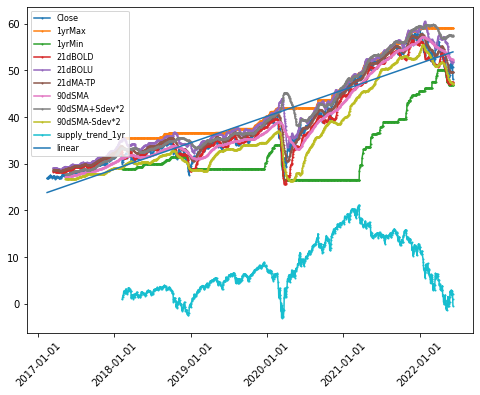

Empty DataFrame
Columns: []
Index: [SPTM]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  47.422277  49.676984  51.931691

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SPTM      1.445517    48.16  10701430.030257  0.514882  0.731043  0.430862

ets next 13 weeks


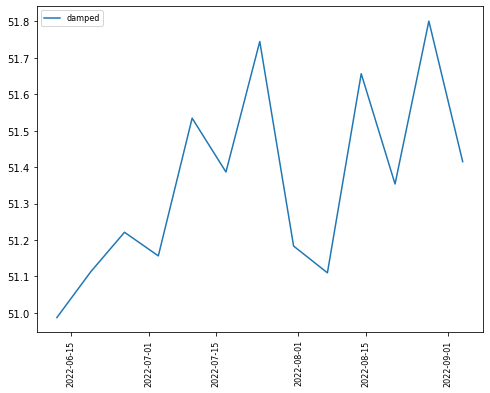

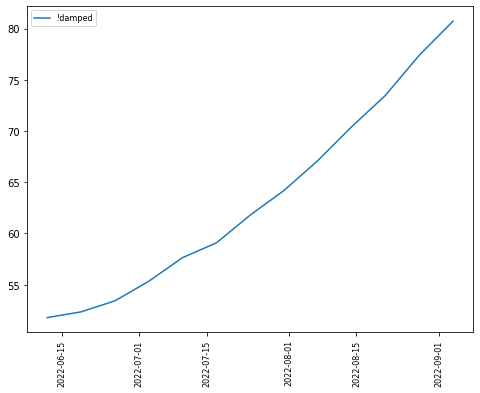

1
['options', ('2022-06-17',)]
SPY
Index: SP500
supply trend: 1781380150.6807866


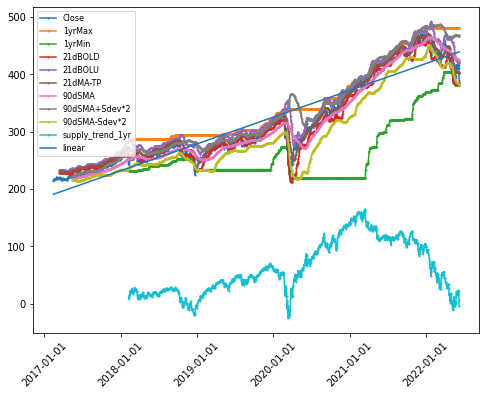

totalAssets  trailingPE
SPY  3.781762e+11    4.292843

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  384.809441  402.729524  420.649606

volume_factor    latest_p        vol_30d_2yr   pct_2yr       adf     hurst
SPY      1.065993  389.799988  1781380150.680787  0.501905  0.730083  0.423507

ets next 13 weeks


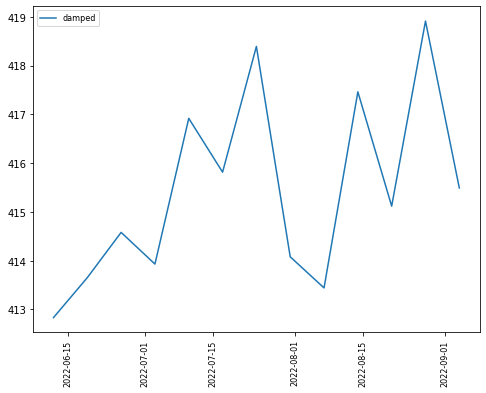

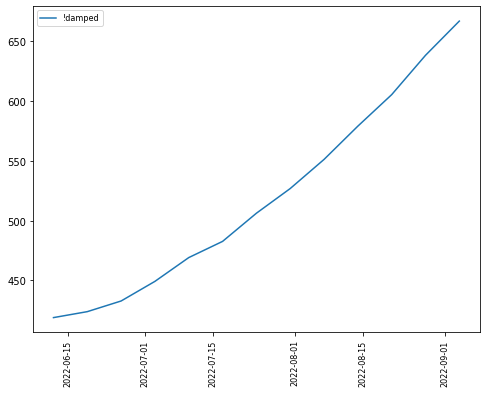

11
['options', ('2022-06-17', '2022-06-30', '2022-09-16', '2022-09-30', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15', '2024-01-19', '2024-12-20')]
SLY
Index: SP600
supply trend: 1733621.860816944


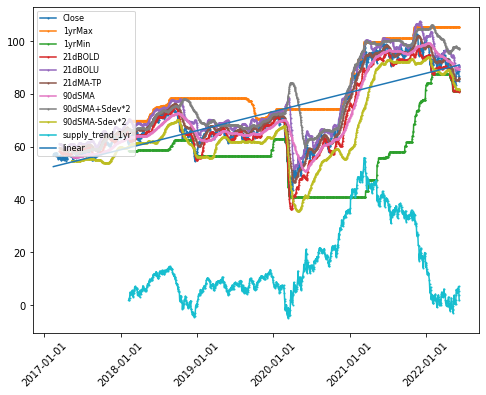

Empty DataFrame
Columns: []
Index: [SLY]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  81.56592  86.101746  90.637572

volume_factor   latest_p     vol_30d_2yr  pct_2yr       adf     hurst
SLY      1.265097  84.790001  1733621.860817  0.58507  0.631357  0.516612

ets next 13 weeks


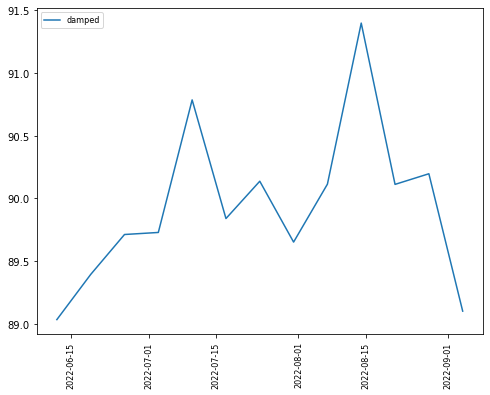

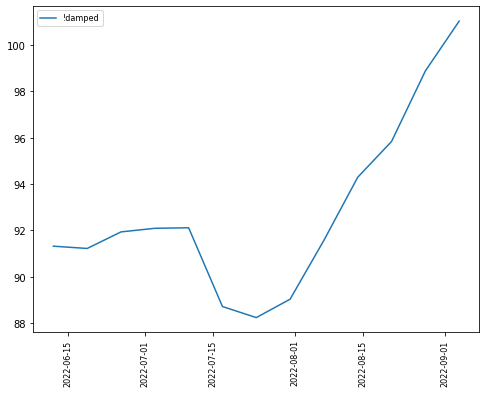

MDYG
Index: SP400
supply trend: 3870598.865355522


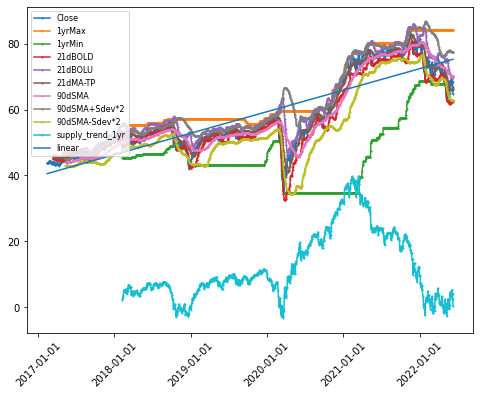

Empty DataFrame
Columns: []
Index: [MDYG]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  62.654627  66.371428  70.088229

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MDYG      0.727588  64.839996  3870598.865356  0.405859  0.564973  0.453632

ets next 13 weeks


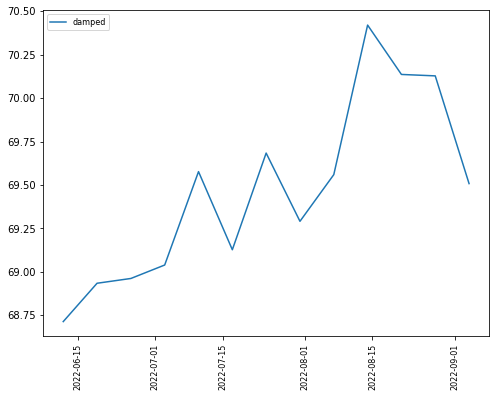

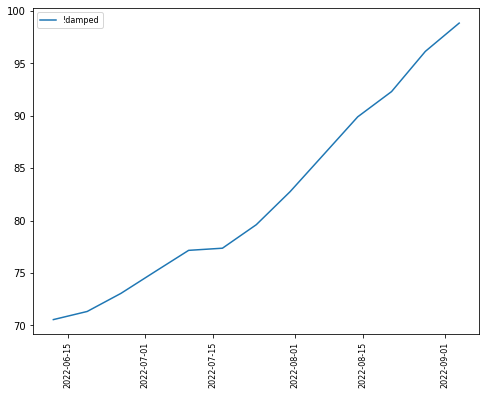

1
['options', ('2022-06-17',)]
VOX
Sector: Communication Services ETF
supply trend: 4281925.491679274


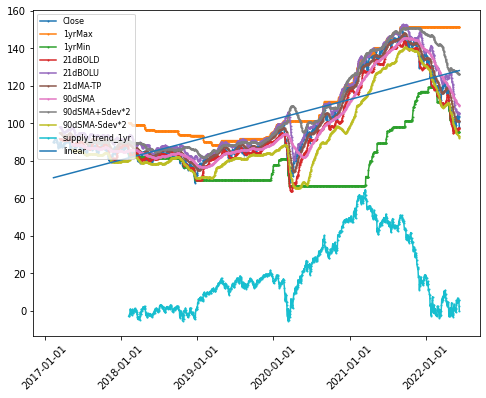

Empty DataFrame
Columns: []
Index: [VOX]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  97.197858  101.223333  105.248808

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VOX      1.950828  97.699997  4281925.491679  0.137637  0.718884  0.512033

ets next 13 weeks


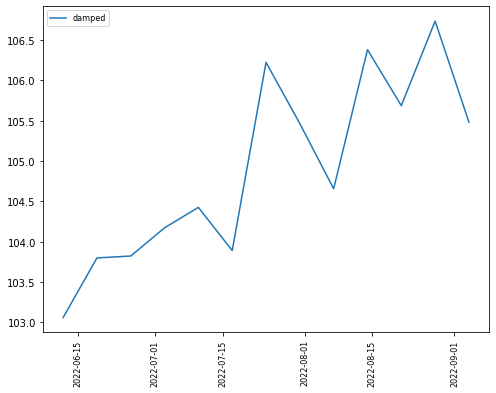

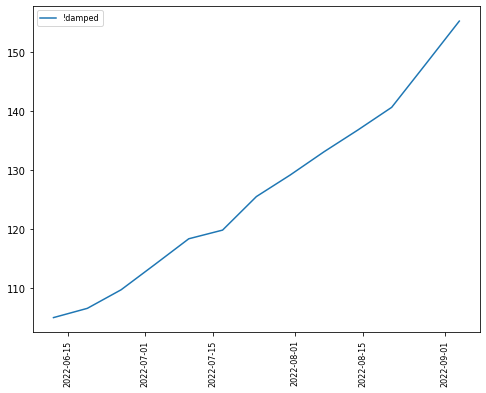

1
['options', ('2022-07-15',)]
VCR
Sector: Consumer Discretionary ETF
supply trend: 2149496.8229954615


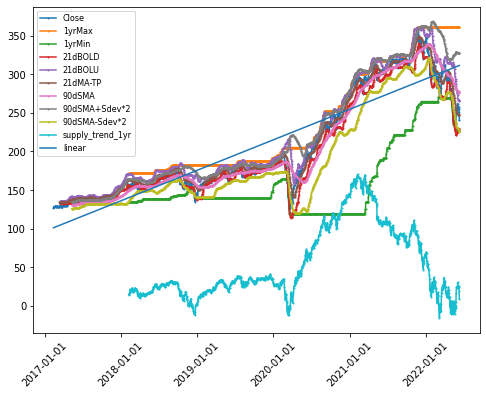

totalAssets
VCR  6.015592e+09

2022-06-10


21dBOLD    21dMA-TP   21dBOLU
2022-06-10  228.960223  247.434761  265.9093

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VCR       1.24671  240.179993  2149496.822995  0.290163  0.672666  0.471633

ets next 13 weeks


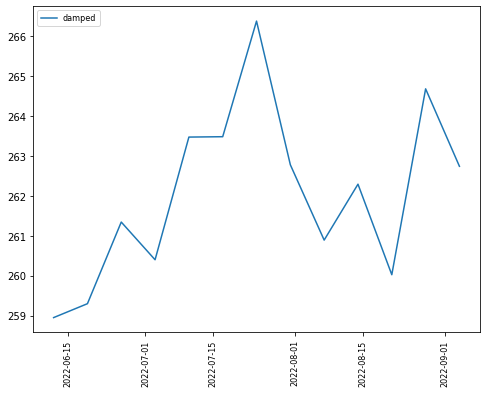

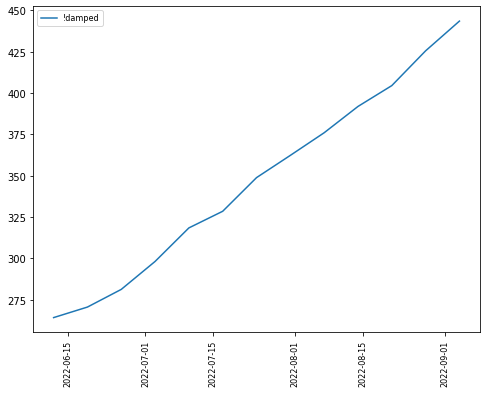

1
['options', ('2022-06-17',)]
VDC
Sector: Consumer Staples ETF
supply trend: 3239531.5431164904


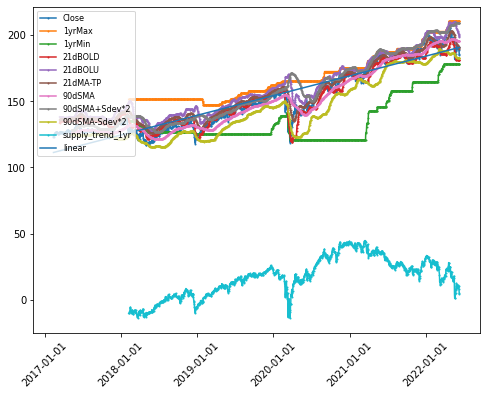

totalAssets
VDC  8.239956e+09

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  180.713861  189.626984  198.540108

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VDC      1.521146  184.889999  3239531.543116  0.610012  0.828818  0.357333

ets next 13 weeks


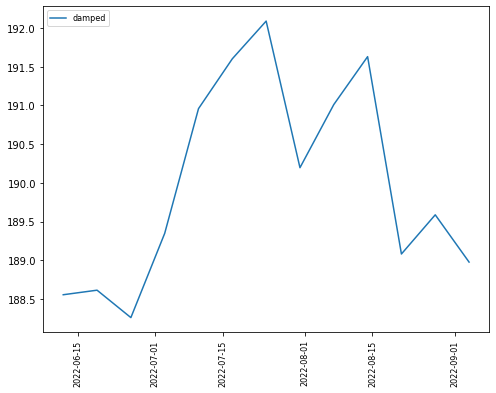

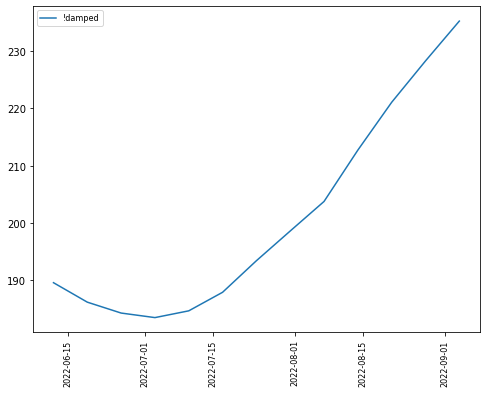

1
['options', ('2022-07-15',)]
VDE
Sector: Energy ETF
supply trend: 15894021.482602118


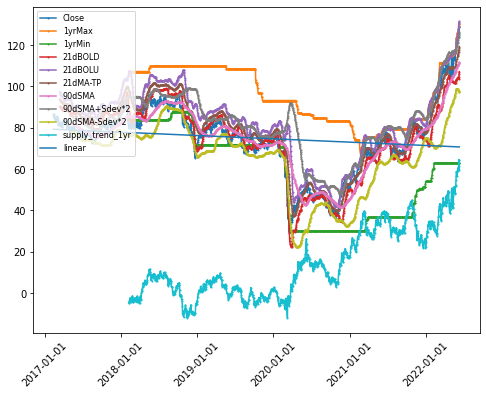

totalAssets  trailingPE
VDE  1.106882e+10   10.692059

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  107.166137  119.294921  131.423705

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf    hurst
VDE      1.169962  123.860001  15894021.482602  0.930759  0.947803  0.52196

ets next 13 weeks


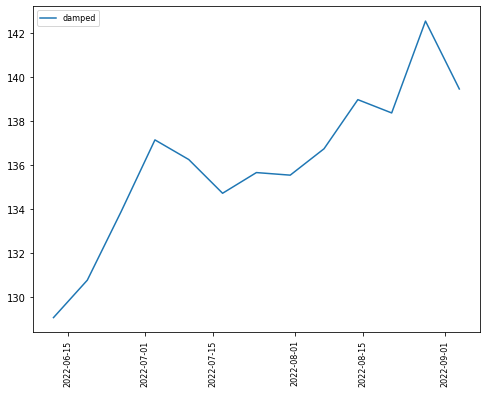

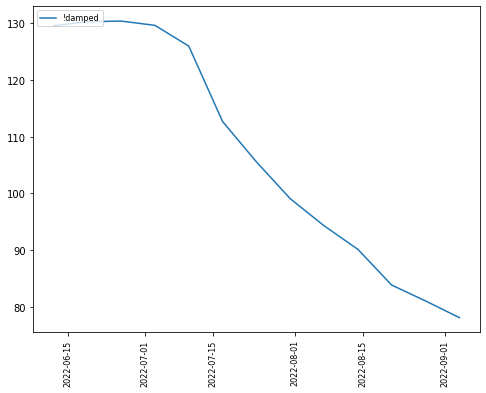

1
['options', ('2022-06-17',)]
VFH
Sector: Financials ETF
supply trend: 15854911.649016641


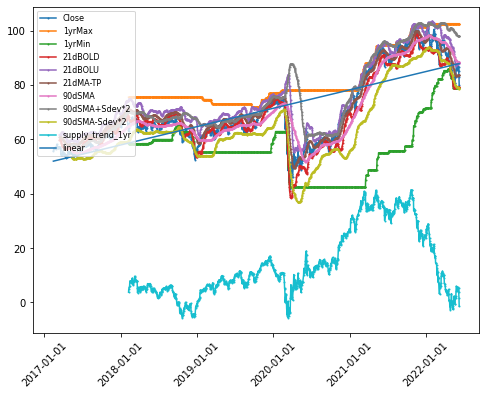

totalAssets
VFH  1.055284e+10

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  79.139405  83.671588  88.203771

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VFH      1.068786    79.93  15854911.649017  0.524221  0.532803  0.492594

ets next 13 weeks


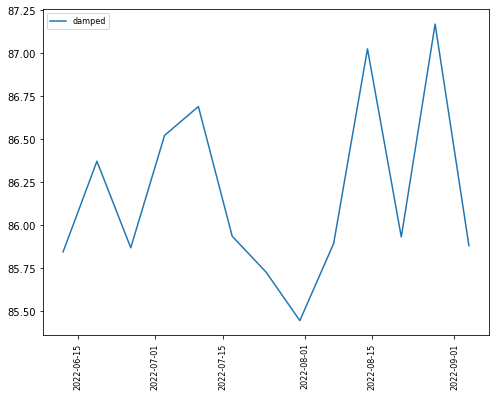

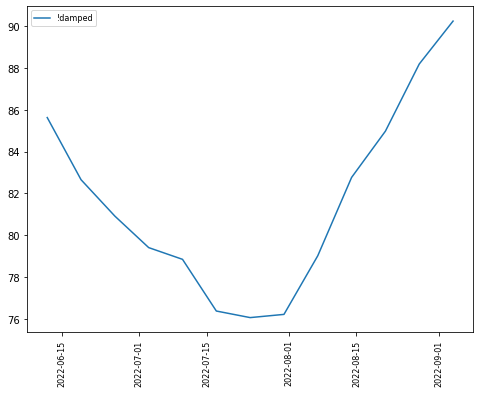

1
['options', ('2022-08-19',)]
VHT
Sector: Health Care ETF
supply trend: 5096065.052950076


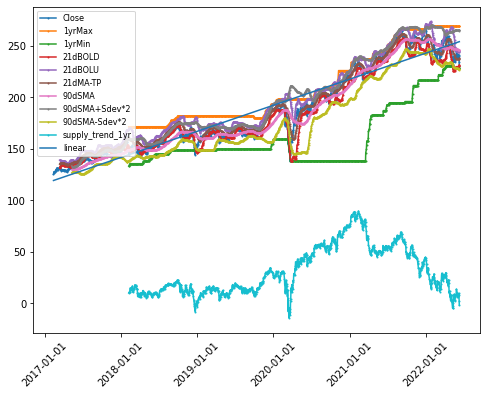

totalAssets  trailingPE
VHT  1.944618e+10    5.167231

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  231.084711  237.690476  244.296241

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VHT      0.947476  229.929993  5096065.05295  0.525621  0.693779  0.333477

ets next 13 weeks


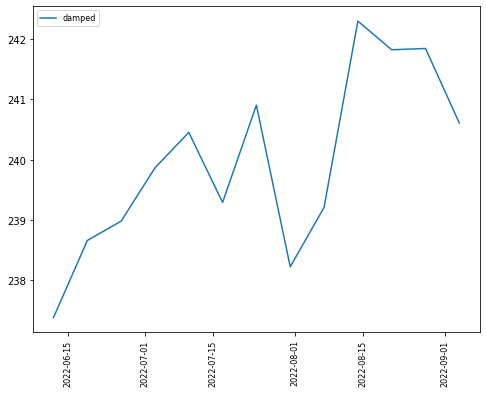

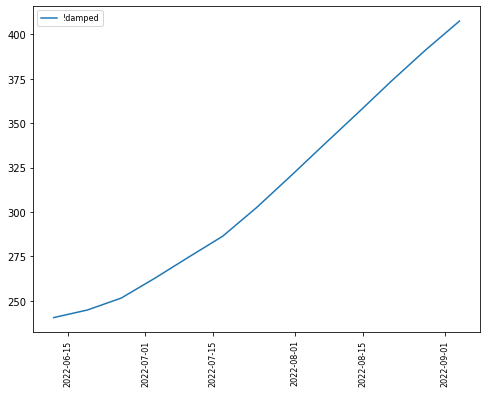

1
['options', ('2022-06-17',)]
VIS
Sector: Industrials ETF
supply trend: 3021835.7791225417


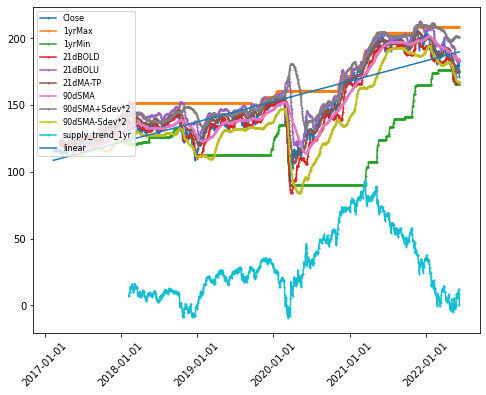

Empty DataFrame
Columns: []
Index: [VIS]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  166.918433  175.029841  183.141249

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
VIS      0.897137  170.789993  3021835.779123  0.55486  0.557365  0.472662

ets next 13 weeks


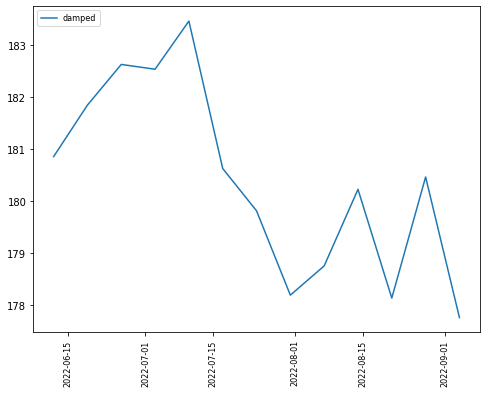

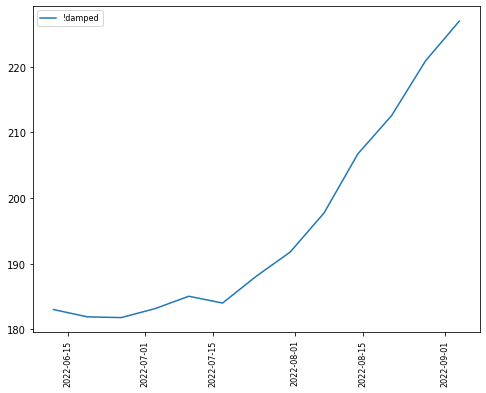

1
['options', ('2022-08-19',)]
VGT
Sector: Information Technology ETF
supply trend: 13900429.727685325


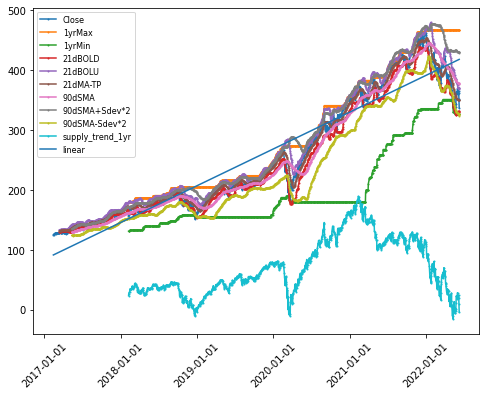

totalAssets
VGT  5.044675e+10

2022-06-10


21dBOLD   21dMA-TP     21dBOLU
2022-06-10  330.411387  350.71381  371.016232

volume_factor    latest_p      vol_30d_2yr pct_2yr       adf     hurst
VGT       1.13554  337.339996  13900429.727685  0.3501  0.739205  0.427823

ets next 13 weeks


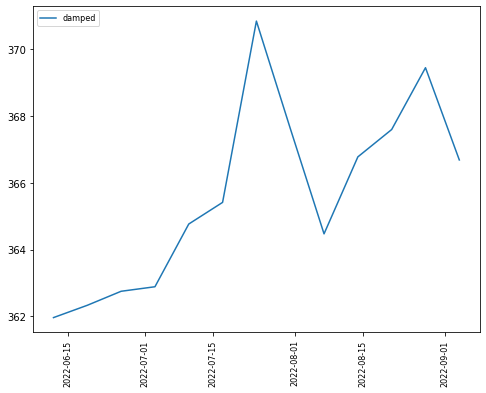

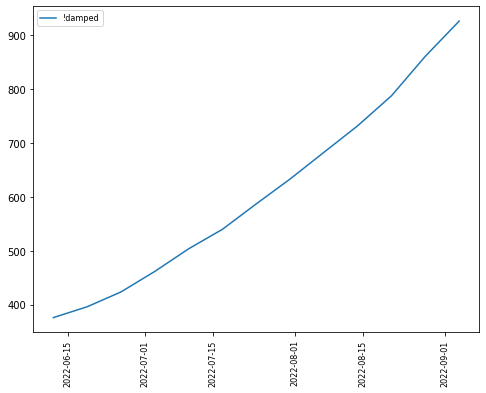

2
['options', ('2022-06-17', '2022-08-19')]
VAW
Sector: Materials ETF
supply trend: 2531724.1301059


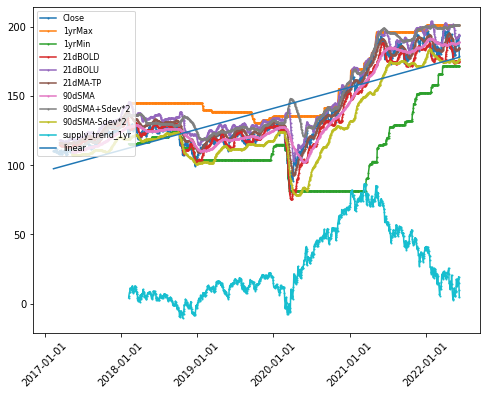

totalAssets
VAW  5.085875e+09

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  175.041332  184.631904  194.222476

volume_factor    latest_p     vol_30d_2yr   pct_2yr     adf     hurst
VAW      1.136419  178.449997  2531724.130106  0.735836  0.8001  0.433204

ets next 13 weeks


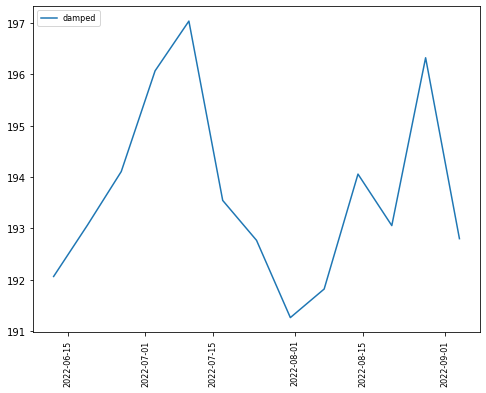

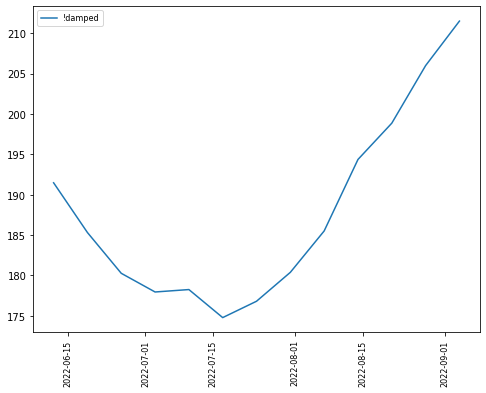

1
['options', ('2022-08-19',)]
VNQ
Sector: Real Estate ETF
supply trend: 111305975.03782149


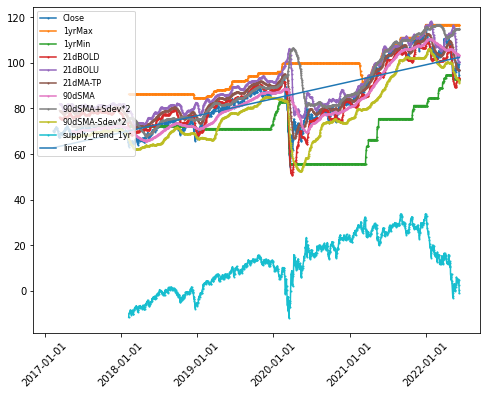

totalAssets
VNQ  7.839537e+10

2022-06-10


21dBOLD   21dMA-TP     21dBOLU
2022-06-10  93.076579  96.729683  100.382786

volume_factor   latest_p       vol_30d_2yr pct_2yr       adf     hurst
VNQ      1.031909  92.620003  111305975.037821   0.416  0.514654  0.397188

ets next 13 weeks


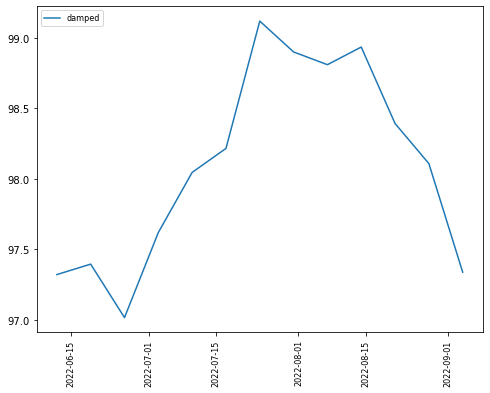

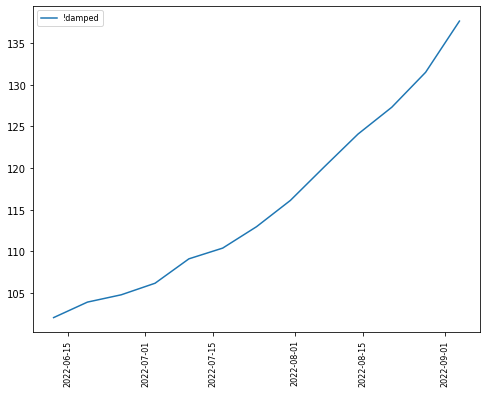

3
['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
VPU
Sector: Utilities ETF
supply trend: 4401008.169440242


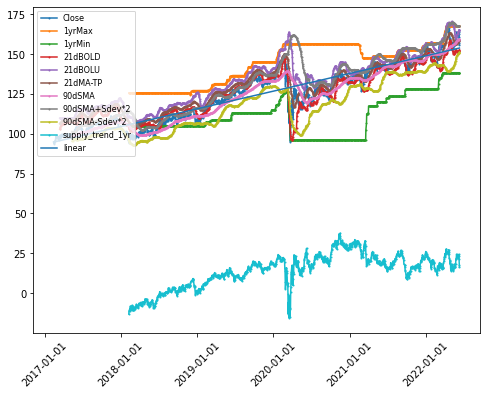

totalAssets
VPU  7.799146e+09

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  152.644005  158.881905  165.119806

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VPU      1.073413  155.610001  4401008.16944  0.750053  0.731044  0.299247

ets next 13 weeks


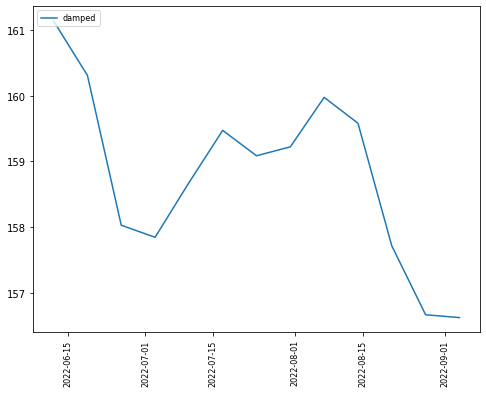

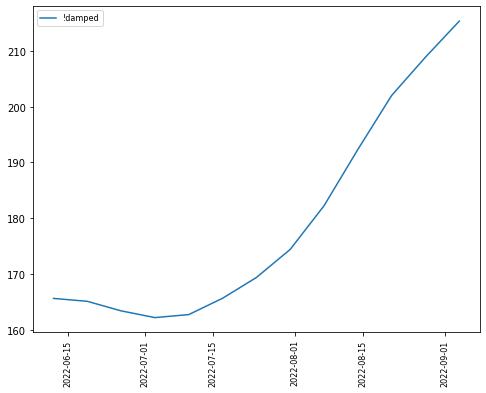

1
['options', ('2022-06-17',)]
ACC
Index: SP400
Sector: error
supply trend: 20837020.877458397


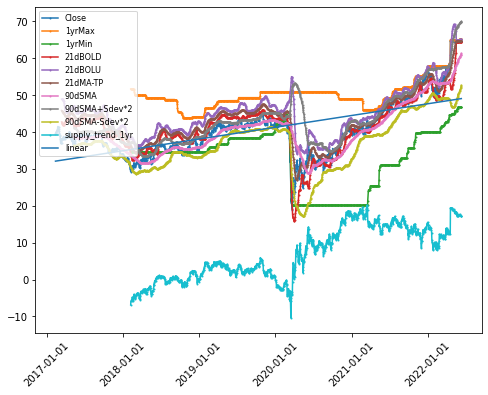

Empty DataFrame
Columns: []
Index: [ACC]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  64.467277  64.776825  65.086373

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
ACC      2.984429  64.769997  20837020.877458  0.986823  0.981927  0.416828

ets next 13 weeks


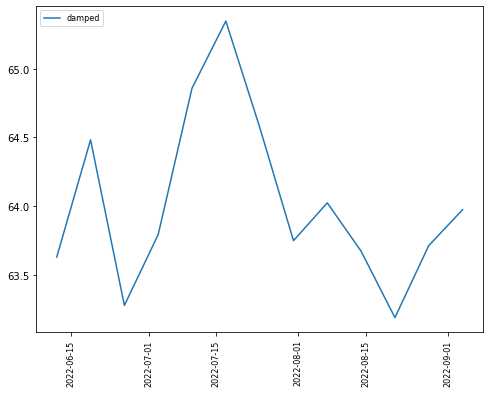

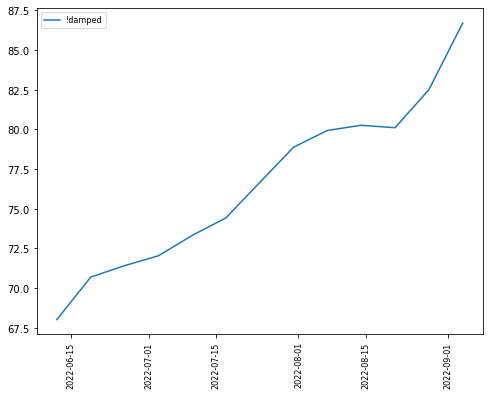

1
['options', ('2022-06-17',)]
APA
Index: SP500
Sector: Energy
supply trend: 154170566.9440242


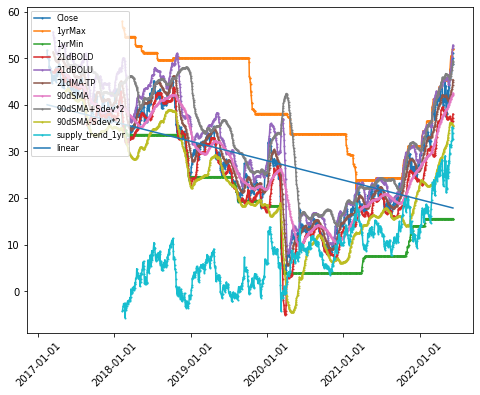

beta currentRatio debtToEquity dividendRate dividendYield  \
APA  4.125226        1.227      704.108          0.5        0.0098   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  ...  \
APA          4.324  4982000128       0.56569   5.04757   2424875008  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
APA         0.405          24.063  Energy         338232000          1   

     totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
APA  234000000             0.692  5999000064   8807000064   7.255835  

[1 rows x 34 columns]

2022-06-10


21dBOLD  21dMA-TP    21dBOLU
2022-06-10  37.987556  45.39127  52.794983

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
APA      1.279846  48.810001  154170566.944024  0.929438  0.443494  0.44772

ets next 13 weeks


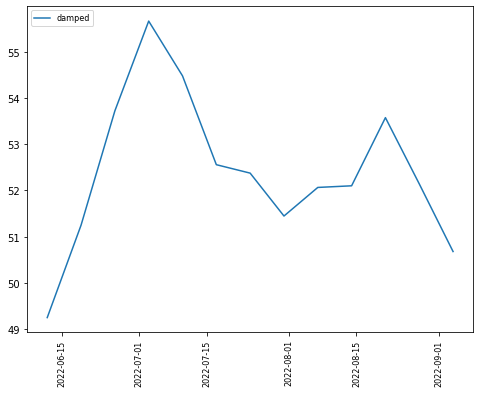

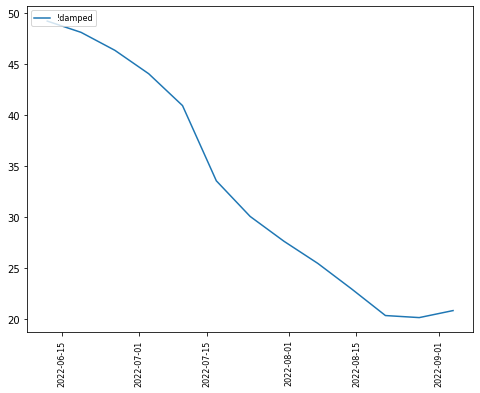

3
['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
27
['sustainability',                                      Value
2021-3                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.88
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               71
governanceScore                       7.96
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             38.81
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides       

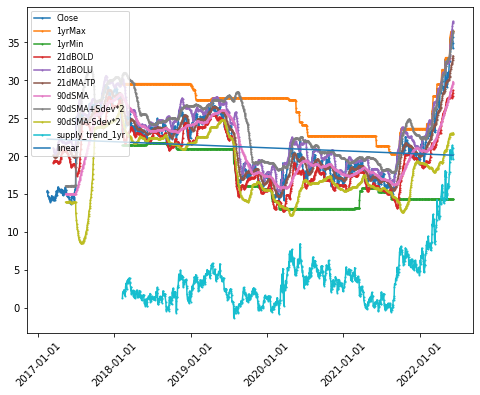

beta currentRatio debtToEquity dividendRate dividendYield  \
CTRA -0.189215        1.751       29.377          0.6        0.0201   

     earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  ...  \
CTRA          2.487  2364999936       0.64441  9.610645   1148249984  ...   

     revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
CTRA         4.191           7.296  Energy         813577984        3.2   

       totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
CTRA  1036000000             1.273  3463000064   3670000128  39.032993  

[1 rows x 35 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  28.660914  33.218095  37.775277

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
CTRA      1.337181  34.310001  150668871.709531  0.899416  0.507048  0.467954

ets next 13 weeks


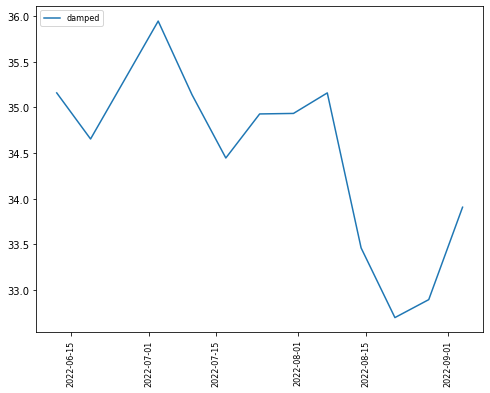

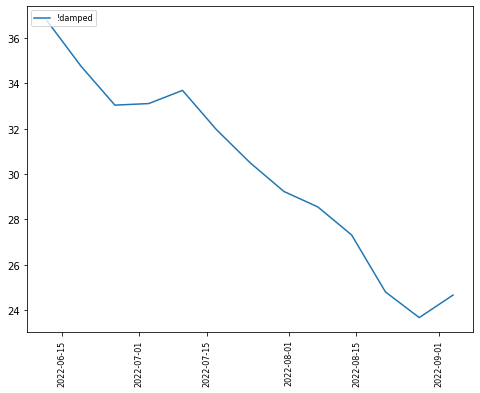

23
['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            1.091100e+10  1.823373e+09  1.815770e+09   
Total Liab                 8.112000e+09  2.404585e+09  2.310672e+09   
Total Stockholder Equity   1.173800e+10  2.326112e+09  2.299895e+09   
Deferred Long Term Liab    5.000000e+06  5.329000e+06  5.844000e+06   
Other Current Liab         1.880000e+08  2.128940e+08  7.719900e+07   
Total Assets               1.990000e+10  4.730697e+09  4.610567e+09   
Common Stock               8.900000e+07  4.786200e+07  4.786200e+07   
Other Current Assets       2.400000e+07  1.323500e+07  1.540000e+07   
Retained Earnings          2.563000e+09  2.276071e+09  2.257320e+09   
Other Liab                 3.512000e+09  9.650310e+08  9.577370e+08   
Treasury Stock            -1.825000e+09 -1.821194e+09 -1.821057e+09   
Other Assets               7.200000e+07  3.109900e+07  3.170800e+07   
Cash                       1.036000e+09  7.627

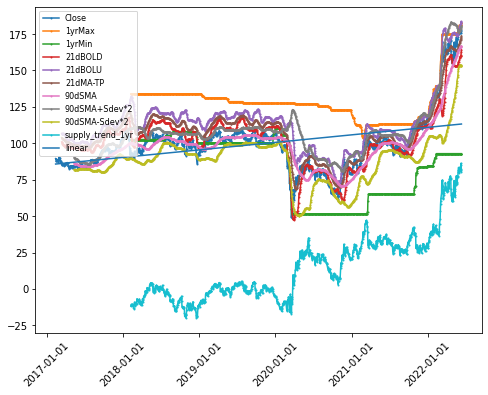

beta currentRatio debtToEquity dividendRate dividendYield  \
CVX  1.078947        1.433       19.941         5.68        0.0315   

    earningsGrowth       ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
CVX          3.473  38521999360       0.21783  12.431709  21073375232  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
CVX         0.683          92.025  Energy        1964809984       2.03   

       totalCash totalCashPerShare    totalDebt  totalRevenue trailingPE  
CVX  11704000512             5.957  29333000192  176843997184    17.0187  

[1 rows x 35 columns]

2022-06-10


21dBOLD    21dMA-TP    21dBOLU
2022-06-10  164.142905  173.680233  183.21756

volume_factor    latest_p       vol_30d_2yr   pct_2yr      adf     hurst
CVX      1.209596  175.399994  181490743.721634  0.940293  0.97985  0.498334

ets next 13 weeks


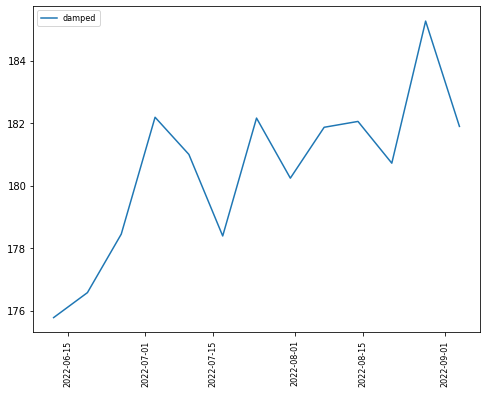

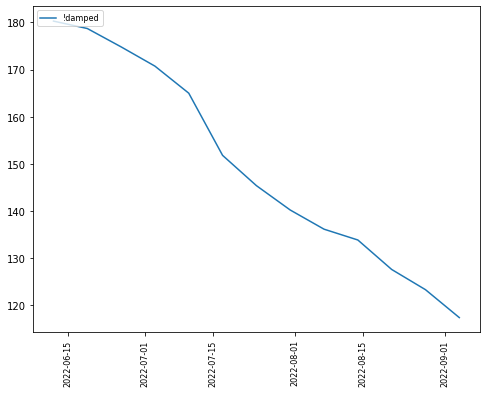

3
['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
27
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          10.63
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       9.95
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                                43
highestControversy                       3
esgPerformance                   LEAD_PERF
coal                                 False
pesticides       

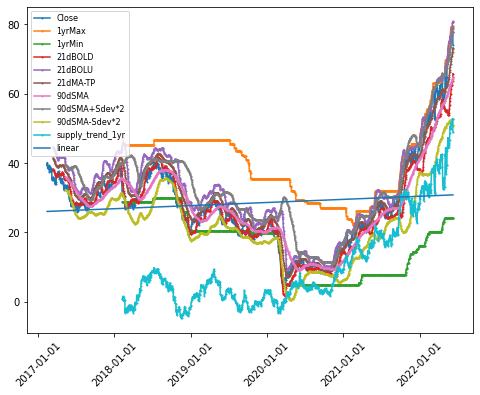

beta currentRatio debtToEquity dividendRate dividendYield  \
DVN  2.784803        1.376       71.922         5.08        0.0739   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  ...  \
DVN  5506999808       0.41984  14.160611   2805625088      0.56522  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
DVN         2.003          19.784  Energy         677000000        1.7   

      totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
DVN  2099000064              3.16  6760000000  13116999680   36.77259  

[1 rows x 34 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  65.748411  73.181587  80.614763

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
DVN      1.304951  74.059998  181231964.523449  0.925492  0.994381  0.555599

ets next 13 weeks


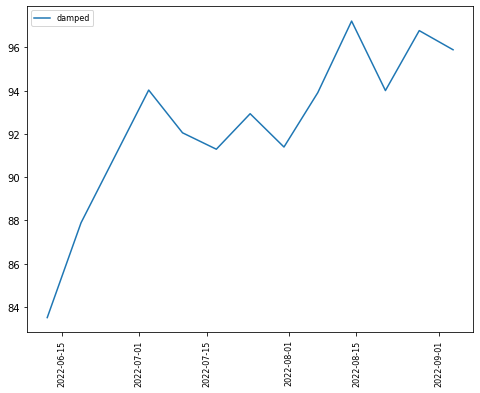

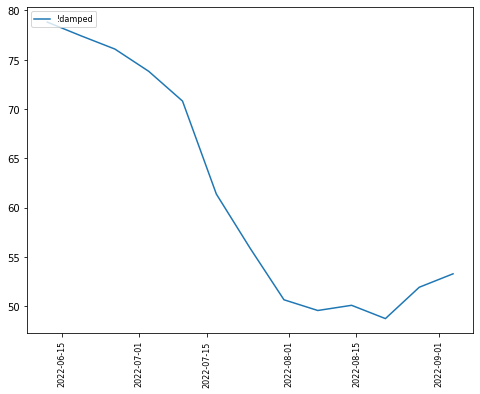

25
['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   7.636000e+09  8.206000e+09  8.189000e+09   
Total Liab                        1.162600e+10  1.199600e+10  1.153000e+10   
Total Stockholder Equity          9.262000e+09  8.924000e+09  8.399000e+09   
Minority Interest                 1.370000e+08  1.370000e+08  1.360000e+08   
Other Current Liab                2.545000e+09  2.940000e+09  2.554000e+09   
Total Assets                      2.102500e+10  2.105700e+10  2.006500e+10   
Common Stock                      6.600000e+07  6.800000e+07  6.800000e+07   
Other Current Assets              5.240000e+08  4.860000e+08  5.030000e+08   
Retained Earnings                 1.692000e+09  7.500000e+08  2.430000e+08   
Other Liab                        1.805000e+09  1.743000e+09  1.698000e+09   
Good Will                         7.530000e+08  7.530000e+08  7.530000e+08   
Treasury Stock                   

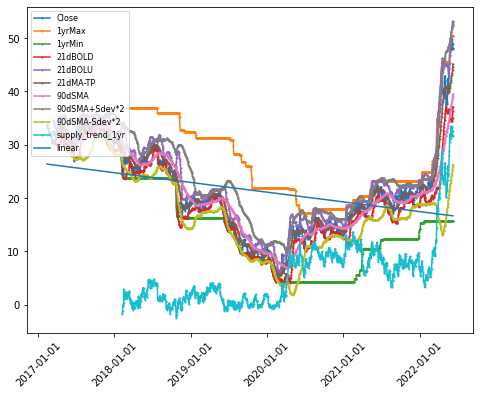

beta currentRatio debtToEquity dividendRate dividendYield  \
EQT  1.156862        0.398       61.543          0.5        0.0133   

          ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  ...  \
EQT  -1089323008      -0.13465  21.603603   2408109568        0.734  ...   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
EQT        -0.3018         1.206          23.313  Energy         377955008   

    shortRatio totalCash totalCashPerShare   totalDebt totalRevenue  
EQT          2  16913000             0.046  5050277888   8089885184  

[1 rows x 32 columns]

2022-06-10


21dBOLD   21dMA-TP   21dBOLU
2022-06-10  37.159954  45.132857  53.10576

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
EQT      1.217357  47.959999  137472571.699697  0.938581  0.932879  0.501911

ets next 13 weeks


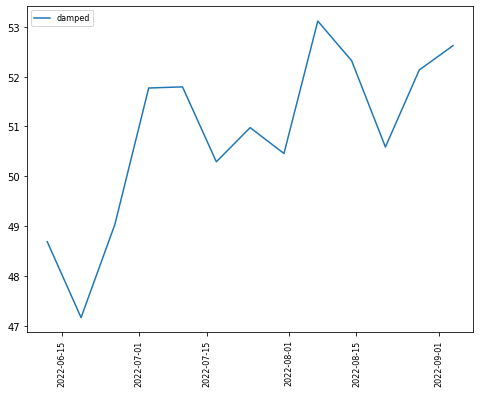

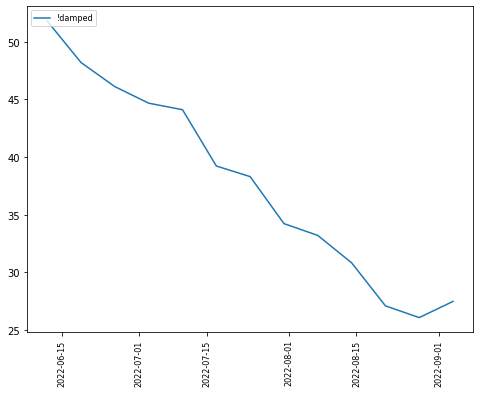

21
['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Total Liab                 1.360858e+10  1.156162e+10  1.475200e+10   
Total Stockholder Equity   8.188673e+09  1.002953e+10  8.248460e+09   
Minority Interest          1.736000e+07  1.623600e+07  1.126500e+07   
Other Current Liab         5.695198e+09  2.471048e+09  6.032718e+09   
Total Assets               2.181461e+10  2.160739e+10  2.301172e+10   
Common Stock               9.921348e+09  1.016796e+10  1.018065e+10   
Other Current Assets       1.304109e+09  6.911100e+08  1.428073e+09   
Retained Earnings         -1.725279e+09 -1.157790e+08 -1.908833e+09   
Other Liab                 1.446828e+09  1.926612e+09  1.346475e+09   
Treasury Stock            -7.396000e+06 -2.265700e+07 -2.335900e+07   
Other Assets               4.927920e+08  8.756020e+08  8.897110e+08   
Cash                       1.691300e+07  1.139630e+08  2.279200e+07   
Total Current Liabilities  7.605287e+09  5.080

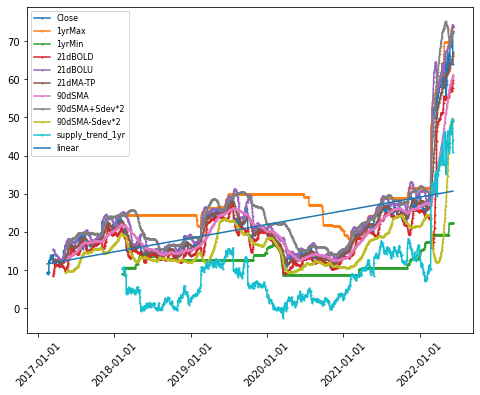

beta currentRatio debtToEquity earningsGrowth     ebitda  \
LNTH  0.750453        1.828       36.846          3.692  108329000   

     ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  ...  \
LNTH       0.20002  21.648647     77142872      0.50913    187695000  ...   

     returnOnEquity revenueGrowth revenuePerShare      sector  \
LNTH       -0.07151         1.258           7.998  Healthcare   

     sharesOutstanding shortRatio  totalCash totalCashPerShare  totalDebt  \
LNTH          68634096          2  105355000             1.535  190072992   

     totalRevenue  
LNTH    541579008  

[1 rows x 32 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  59.745909  66.695412  73.644916

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
LNTH      2.300963  63.849998  10889615.279879  0.843029  0.990883  0.532857

ets next 13 weeks


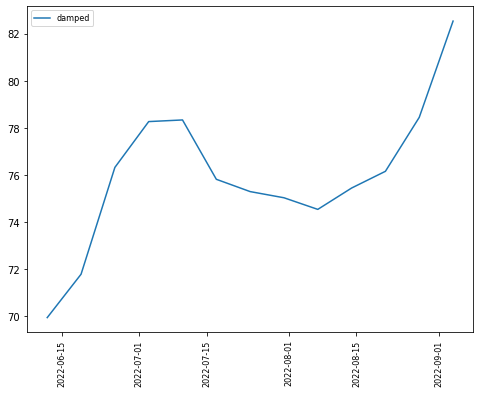

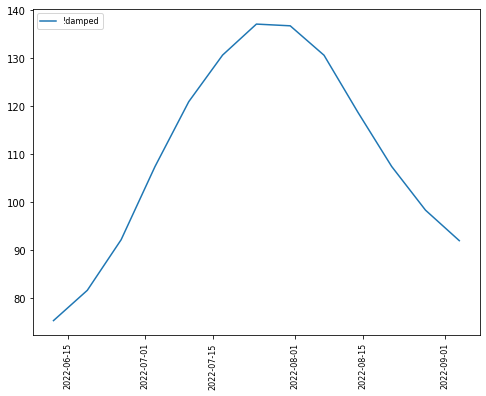

1
['options', ('2022-07-15',)]
MCK
Index: SP500
Sector: Healthcare
supply trend: 33946622.76853253


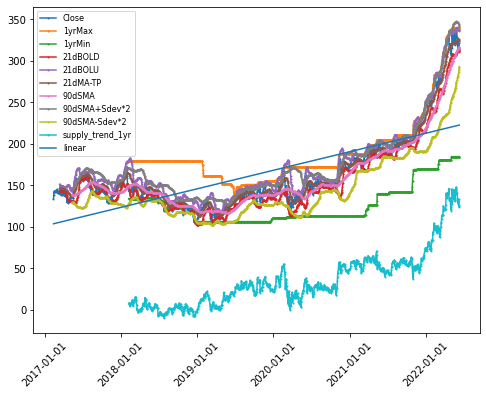

beta currentRatio dividendRate dividendYield earningsGrowth  \
MCK  0.663839        0.954         1.88        0.0059         -0.406   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  ...  \
MCK  3191000064       0.01209  12.411926   2685625088      0.04957  ...   

    revenueGrowth revenuePerShare      sector sharesOutstanding shortRatio  \
MCK         0.118        1733.198  Healthcare         145364992       2.18   

      totalCash totalCashPerShare   totalDebt  totalRevenue trailingPE  
MCK  3532000000            24.297  7616999936  263965999104  43.771442  

[1 rows x 32 columns]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  310.325661  323.309364  336.293067

volume_factor    latest_p      vol_30d_2yr  pct_2yr       adf     hurst
MCK      0.653279  313.339996  33946622.768533  0.86712  0.998714  0.463166

ets next 13 weeks


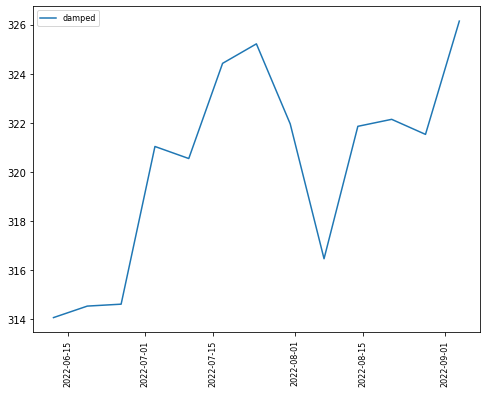

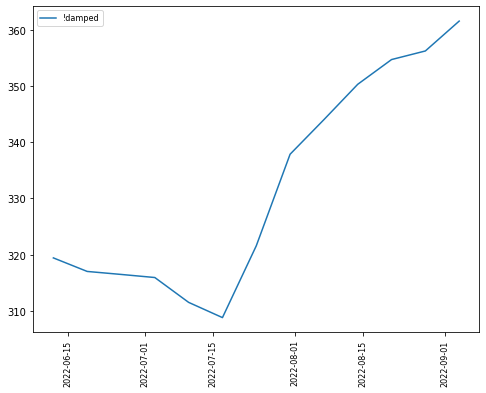

3
['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
27
['sustainability',                             Value
2022-5                           
palmOil                     False
controversialWeapons        False
gambling                    False
socialScore                  7.37
nuclear                     False
furLeather                  False
alcoholic                   False
gmo                         False
catholic                    False
socialPercentile             None
peerCount                      58
governanceScore              5.52
environmentPercentile        None
animalTesting               False
tobacco                     False
totalEsg                    15.17
highestControversy              3
esgPerformance         UNDER_PERF
coal                        False
pesticides                  False
adult                       False
percentile                  10.18
peerGroup              Healthcare
smallArms                   False
environmentScore             2.29
go

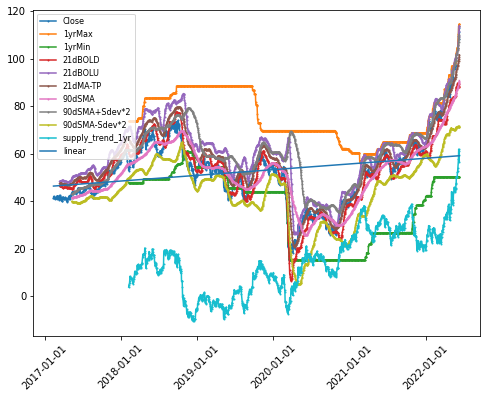

beta currentRatio debtToEquity dividendRate dividendYield  \
MPC  1.910294        1.704       80.117         2.32        0.0242   

    earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
MPC          1.917  7120999936       0.05912  25.672987  16415250432  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
MPC         0.967         189.986  Energy         615587968       2.92   

       totalCash totalCashPerShare    totalDebt  totalRevenue trailingPE  
MPC  10839000064            19.177  26904000512  120450998272   7.604941  

[1 rows x 35 columns]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  89.236784  101.560094  113.883404

volume_factor    latest_p       vol_30d_2yr   pct_2yr       adf     hurst
MPC      0.997729  108.339996  132481329.198185  0.931541  0.991702  0.523957

ets next 13 weeks


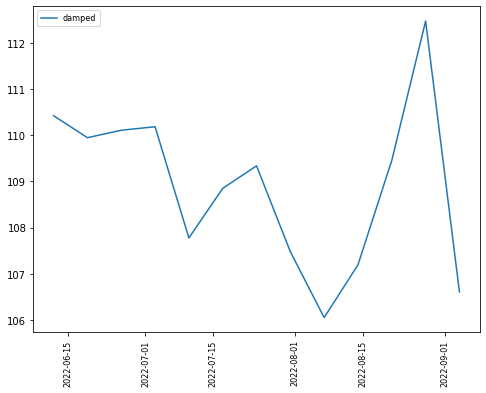

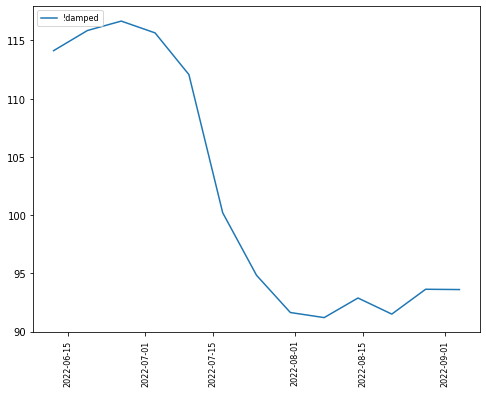

27
['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   3.326200e+10  3.325600e+10  3.323800e+10   
Total Liab                        5.179200e+10  5.333600e+10  5.760700e+10   
Total Stockholder Equity          2.620600e+10  2.828000e+10  2.892100e+10   
Minority Interest                 7.375000e+09  7.684000e+09  7.772000e+09   
Other Current Liab                2.278000e+09  3.377000e+09  6.148000e+09   
Total Assets                      8.537300e+10  8.930000e+10  9.430000e+10   
Common Stock                      1.000000e+07  1.000000e+07  1.000000e+07   
Other Current Assets              5.680000e+08  5.850000e+08  5.850000e+08   
Retained Earnings                 1.290500e+10  1.248400e+10  1.216000e+10   
Other Liab                        7.999000e+09  8.193000e+09  8.825000e+09   
Good Will                         8.256000e+09  8.256000e+09  8.256000e+09   
Treasury Stock                   

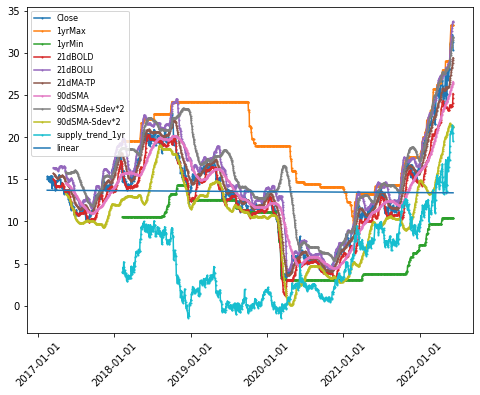

beta currentRatio debtToEquity dividendRate dividendYield  \
MRO  2.766666        1.112        38.48         0.32        0.0119   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  ...  \
MRO  3308999936       0.58921  15.454082   1785500032      0.77546  ...   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
MRO        0.08905         1.091           7.136  Energy         778537024   

    shortRatio  totalCash totalCashPerShare   totalDebt totalRevenue  
MRO       0.93  580000000             0.794  4112000000   5616000000  

[1 rows x 33 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  25.156063  29.418428  33.680793

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
MRO      1.127529  30.290001  385905130.635401  0.900034  0.972772  0.54597

ets next 13 weeks


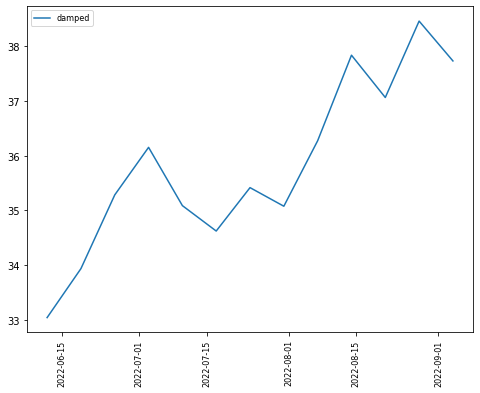

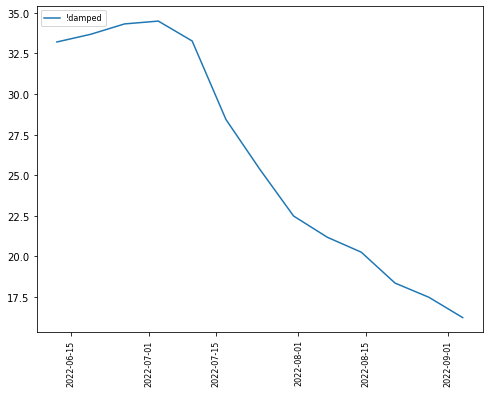

23
['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
Total Current Liabilities  1.637000e+09  1.676

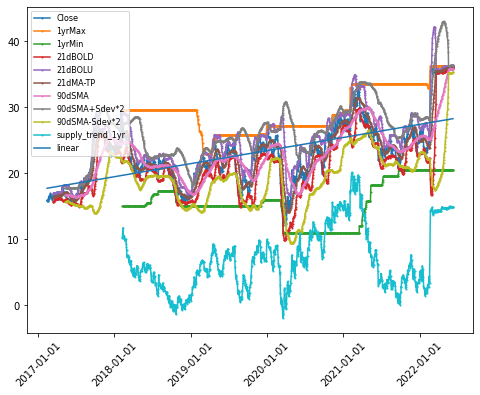

Empty DataFrame
Columns: []
Index: [MTOR]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  35.91395  36.090158  36.266367

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MTOR      1.167952  36.119999  20301256.12708  0.990077  0.308552  0.433895

ets next 13 weeks


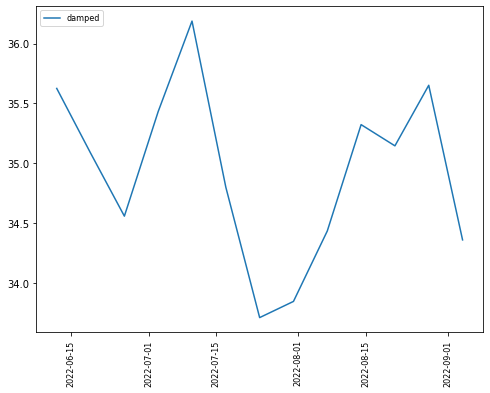

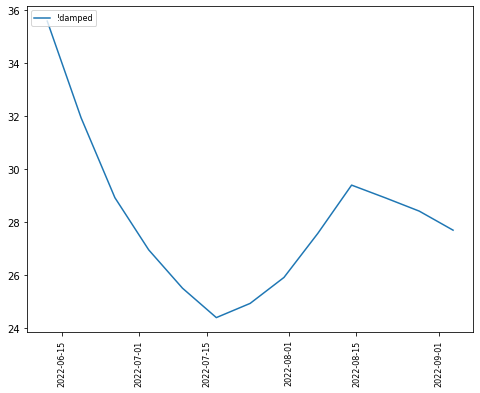

1
['options', ('2022-08-19',)]
MUSA
Index: SP400
Sector: Consumer Cyclical
supply trend: 7365132.299546142


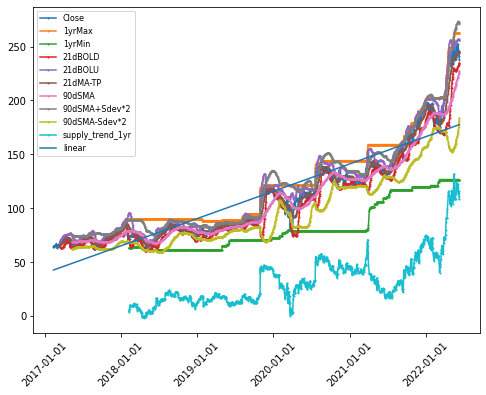

beta currentRatio debtToEquity dividendRate dividendYield  \
MUSA  0.820982        1.083      283.285         1.24         0.005   

     earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
MUSA          2.025  950200000       0.05637  19.691177    451787488  ...   

     revenueGrowth revenuePerShare             sector sharesOutstanding  \
MUSA         0.501         658.653  Consumer Cyclical          24201600   

     shortRatio  totalCash totalCashPerShare   totalDebt totalRevenue  \
MUSA        4.6  356200000            14.718  2242200064  16855600128   

     trailingPE  
MUSA  13.386478  

[1 rows x 35 columns]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  234.45771  245.340318  256.222926

volume_factor    latest_p     vol_30d_2yr   pct_2yr      adf     hurst
MUSA      1.023661  237.960007  7365132.299546  0.839578  0.99617  0.410367

ets next 13 weeks


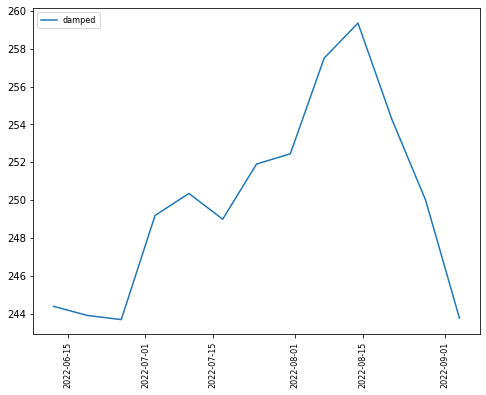

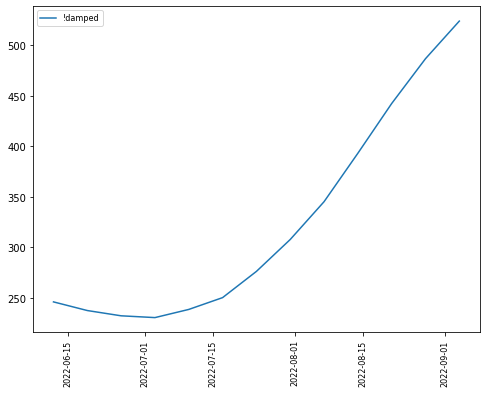

2
['options', ('2022-07-15', '2022-11-18')]
PBF
Index: SP600
Sector: Energy
supply trend: 65359710.136157334


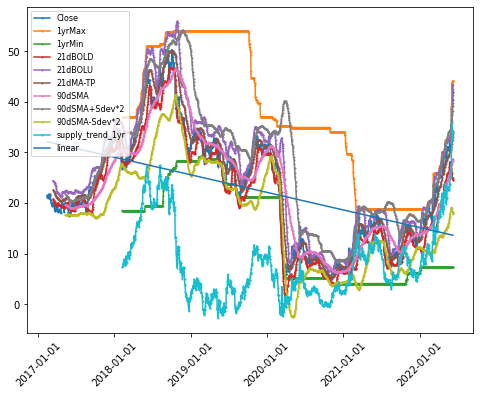

beta currentRatio debtToEquity     ebitda ebitdaMargins  forwardPE  \
PBF  2.259981        1.254      197.914  690400000       0.02194  14.665455   

    freeCashflow grossMargins grossProfits heldPercentInstitutions  ...  \
PBF    284750016       0.0362    671100000                 0.80126  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
PBF         0.856         261.505  Energy         120828000       2.81   

      totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
PBF  1434599936            11.873  4999499776  31470299136  19.549202  

[1 rows x 32 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  24.95881  34.143016  43.327222

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PBF      1.018074  40.330002  65359710.136157  0.905392  0.730477  0.555776

ets next 13 weeks


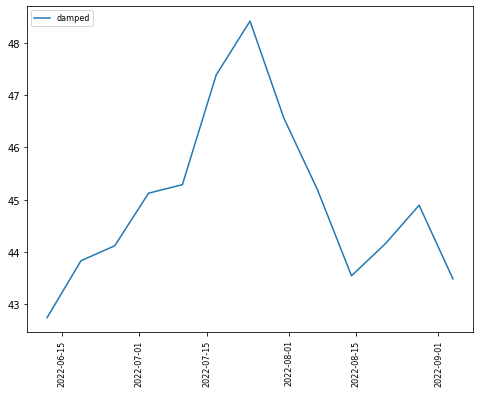

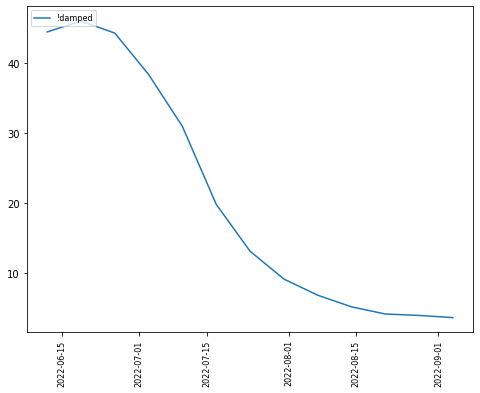

5
['options', ('2022-06-17', '2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
SJI
Index: SP600
Sector: Utilities
supply trend: 18167782.072617248


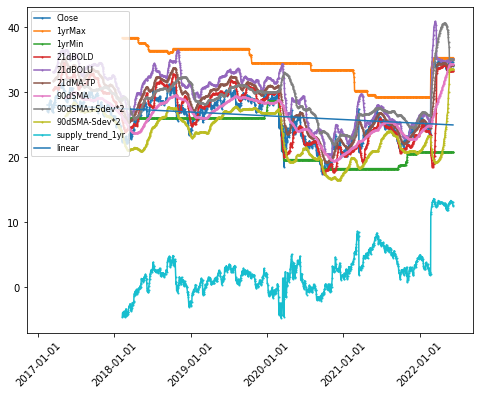

beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
SJI  0.767156        0.669      180.745         1.24        0.0371  563539008   

    ebitdaMargins forwardPE freeCashflow grossMargins  ... returnOnEquity  \
SJI        0.2829  20.39521   -181286880      0.24213  ...        0.04828   

    revenuePerShare     sector sharesOutstanding shortRatio totalCash  \
SJI           18.23  Utilities         112448000       3.26  28754000   

    totalCashPerShare   totalDebt totalRevenue trailingPE  
SJI             0.245  3613896960   1991996032  48.587734  

[1 rows x 33 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  33.346404  34.247778  35.149152

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
SJI       1.10309  34.060001  18167782.072617  0.92623  0.165217  0.413386

ets next 13 weeks


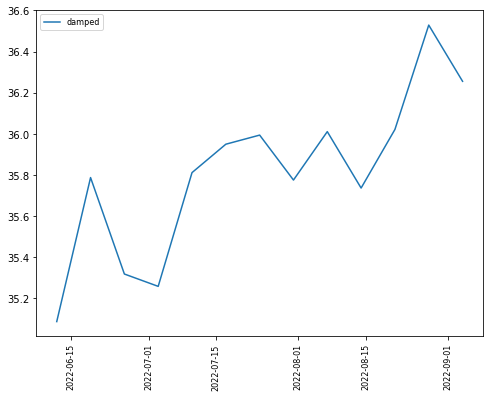

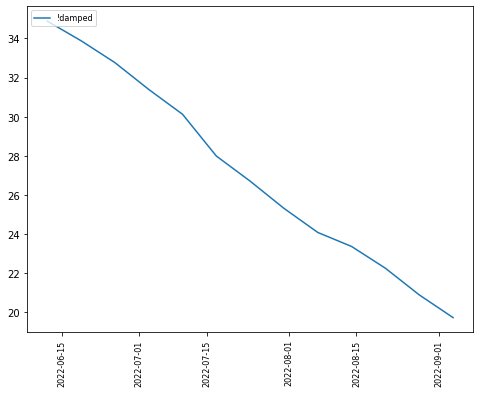

27
['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          1.404300e+07  1.473100e+07  1.611800e+07   
Capital Surplus            1.559060e+09  1.463655e+09  1.462322e+09   
Total Liab                 5.309231e+09  5.187967e+09  4.938285e+09   
Total Stockholder Equity   1.989152e+09  1.828587e+09  1.887399e+09   
Minority Interest          1.028900e+07  7.457000e+06  7.425000e+06   
Deferred Long Term Liab    6.724160e+08  6.694870e+08  6.701760e+08   
Other Current Liab         1.596050e+08  2.273930e+08  1.760970e+08   
Total Assets               7.308672e+09  7.024011e+09  6.833109e+09   
Common Stock               1.466750e+08  1.405610e+08  1.405570e+08   
Other Current Assets       9.504100e+07  1.416900e+08  8.351100e+07   
Retained Earnings          3.104330e+08  2.628420e+08  3.229880e+08   
Other Liab                 1.141049e+09  1.165851e+09  1.163466e+09   
Good Will                  7.069600e+08  7.069

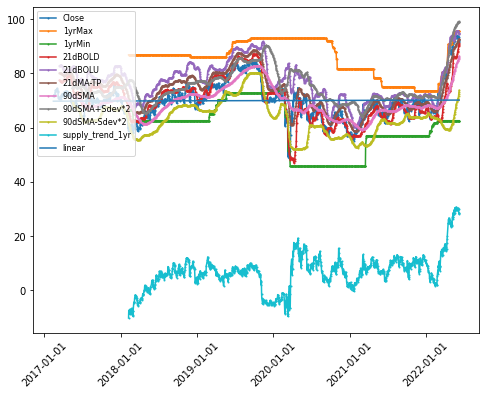

beta currentRatio debtToEquity dividendRate dividendYield  \
SWX  0.108035        0.778      174.475         2.48        0.0263   

    earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
SWX         -0.222  786628992       0.19366  19.052631   -470833120  ...   

    revenueGrowth revenuePerShare     sector sharesOutstanding shortRatio  \
SWX         0.431          67.779  Utilities          66852000       1.78   

     totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
SWX  624665984             9.344  6324827136   4061953024   31.40474  

[1 rows x 35 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  91.063144  92.741905  94.420666

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
SWX       1.47625  91.889999  7059509.304085  0.903418  0.284442  0.398907

ets next 13 weeks


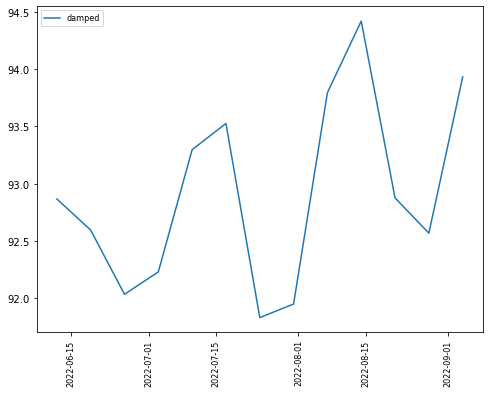

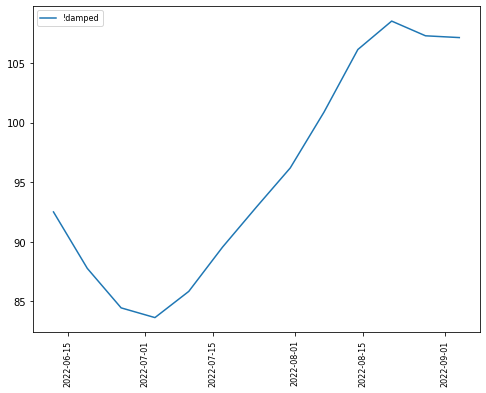

1
['options', ('2022-07-15',)]
TVTY
Index: SP600
Sector: error
supply trend: 14974563.993948562


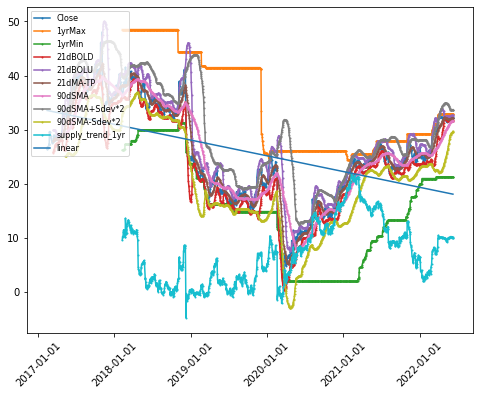

Empty DataFrame
Columns: []
Index: [TVTY]

2022-06-10


21dBOLD   21dMA-TP   21dBOLU
2022-06-10  31.743907  32.163968  32.58403

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TVTY      0.975728  32.279999  14974563.993949  0.973128  0.524133  0.449983

ets next 13 weeks


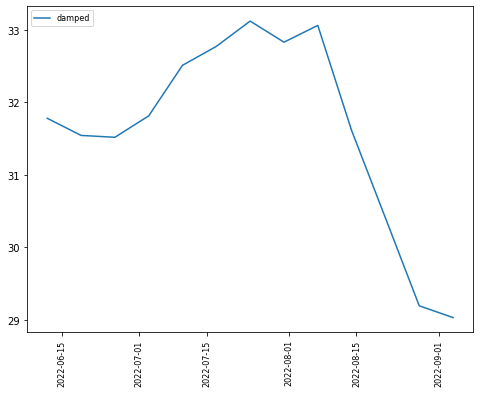

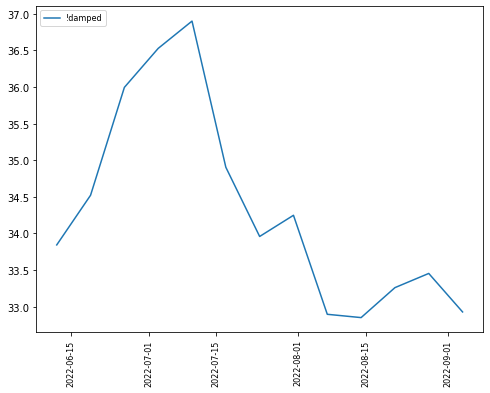

1
['options', ('2022-08-19',)]
XOM
Index: SP500
Sector: Energy
supply trend: 399482859.5310136


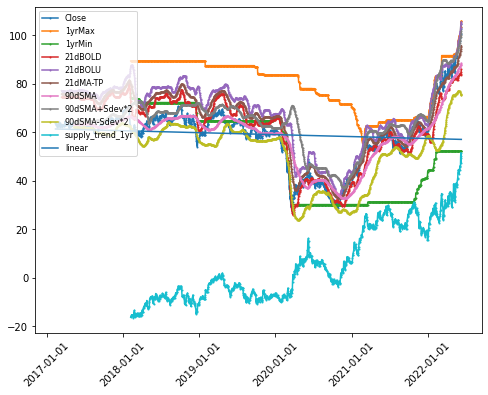

beta currentRatio debtToEquity dividendRate dividendYield  \
XOM  1.040834        1.072       26.929         3.52        0.0341   

    earningsGrowth       ebitda ebitdaMargins  forwardPE freeCashflow  ...  \
XOM          1.003  53895000064       0.17427  11.818078  31484874752  ...   

    revenueGrowth revenuePerShare  sector sharesOutstanding shortRatio  \
XOM         0.525          72.369  Energy        4213199872       1.13   

       totalCash totalCashPerShare    totalDebt  totalRevenue trailingPE  
XOM  11073999872             2.629  47537000448  309269004288   17.34494  

[1 rows x 35 columns]

2022-06-10


21dBOLD   21dMA-TP    21dBOLU
2022-06-10  85.804488  95.616984  105.42948

volume_factor    latest_p       vol_30d_2yr   pct_2yr       adf     hurst
XOM      1.434399  100.459999  399482859.531014  0.931373  0.977852  0.536671

ets next 13 weeks


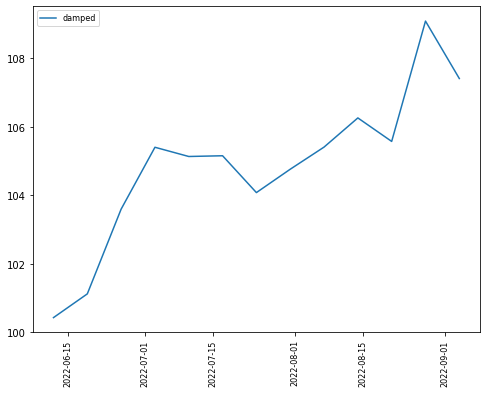

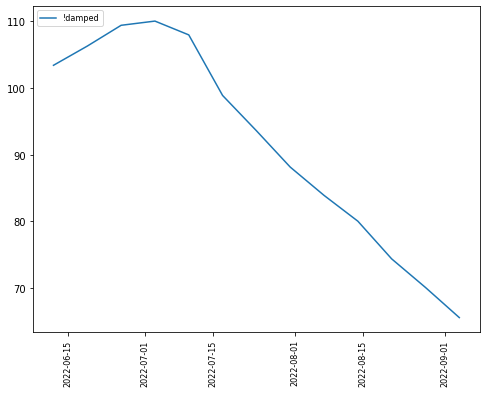

5
['options', ('2022-06-17', '2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')]
27
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.82
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.14
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                             36.46
highestControversy                       3
esgPerformance                    OUT_PERF
coal                            

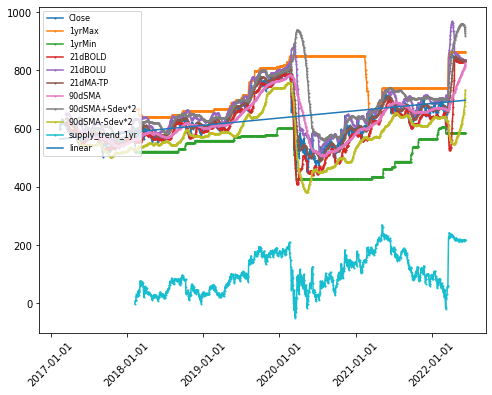

beta currentRatio debtToEquity earningsGrowth      ebitda  \
Y  0.663839        1.597         31.5         -0.433  1620000000   

  ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  ...  \
Y       0.13423  9.936376     90016496      0.44211   5101669000  ...   

  revenueGrowth revenuePerShare              sector sharesOutstanding  \
Y         0.025         878.577  Financial Services          13454900   

  shortRatio   totalCash totalCashPerShare   totalDebt totalRevenue trailingPE  
Y       2.32  2298860032           170.857  2822777088  12069126144  12.311554  

[1 rows x 33 columns]

2022-06-10


21dBOLD    21dMA-TP     21dBOLU
2022-06-10  831.51432  833.616982  835.719644

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
Y      1.713893  834.109985  1456858.698941  0.928509  0.389055  0.457411

ets next 13 weeks


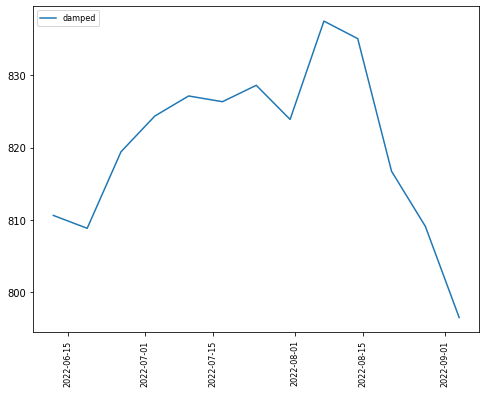

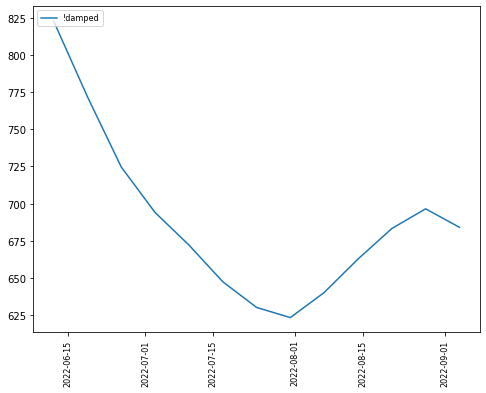

1
['options', ('2022-07-15',)]
27
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 8.71
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            11.77
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.71
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 30.32
peerGroup              Insurance
smallArms                  False
environmentScore            1.23
governancePercentile        None
militaryContract       

In [53]:
import statsmodels.api as sm

#from matplotlib.pyplot import figure

#figure(figsize=(8, 8), dpi=80)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in [*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,*np.setdiff1d(np.setdiff1d(screened_final_set.index,temp_v['Symbol'].values),spdr_indexes.iloc[:,0].values)]:
    print(s)
    subset=prices[prices['Symbol']==s]
    
    if(np.sum(spdr_indexes['Symbol'].values==s)>0):
        print("Index:",spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0])
    elif(np.sum(vanguard_sectors['Symbol'].values==s)>0):
        print("Sector:",vanguard_sectors.iloc[np.where(vanguard_sectors['Symbol'].values==s)].index[0])
    else:
        print("Index:", stock_indexes.iloc[np.where(np.array(stock_indexes['Symbol'])==s)[0][0]]['Market Index'])
        print("Sector:", stock_sectors.iloc[np.where(np.array(stock_sectors.index)==s)][0])                
    
    print("supply trend:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    
    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal
    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    fig, ax = plt.subplots()
    
    msize = 2
    plt.plot(x, y,marker = '.',markersize=msize)
    plt.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize)
    plt.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize)
    
    plt.plot(x, subset['21dBOLD'],marker = '.',markersize=msize)
    plt.plot(x, subset['21dBOLU'],marker = '.',markersize=msize)
    plt.plot(x, subset['21dMA-TP'],marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA'],marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA']+subset['90dSDev']*2,marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA']-subset['90dSDev']*2,marker = '.',markersize=msize)
    
    plt.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize)
    
    plt.plot(x, mymodel)
    
    labels = ['Close','1yrMax','1yrMin','21dBOLD','21dBOLU','21dMA-TP','90dSMA','90dSMA+Sdev*2','90dSMA-Sdev*2','supply_trend_1yr','linear']
    
    plt.legend(labels, fontsize=8,loc=2)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.show()
    
    temp = pd.DataFrame(stock_fundamentals.loc[s])
    display(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)
    
    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]
    
    print(last_date)
    bbands = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']]).T
    #print(bbands)
    bbands.index = [last_date]
    display(bbands)
    display(pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']]))
    
    print("ets next 13 weeks")
    
    ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(np.log(subset['Adj Close'].asfreq('D').interpolate().asfreq('W')),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=True).fit()
    ets_LAdA_ndt=sm.tsa.statespace.ExponentialSmoothing(np.log(subset['Adj Close'].asfreq('D').interpolate().asfreq('W')),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=True).fit()

    fc_LAdA = np.exp(ets_LAdA.forecast(13)) #inverting the Log
    fc_LAdA_ndt = np.exp(ets_LAdA_ndt.forecast(13)) #inverting the Log    
    plt.plot(fc_LAdA)
    plt.xticks(rotation = 90,size=8)
    plt.legend(['damped'], fontsize=8,loc=2)
    plt.show()
    plt.plot(fc_LAdA_ndt)    
    plt.xticks(rotation = 90,size=8)
    plt.legend(['!damped'], fontsize=8,loc=2)
    plt.show()

    #display(pd.DataFrame(stock_fundamentals.set_index(stock_fundamentals.iloc[:,0]).loc[s]).dropna().T)
    
    #evaluate_models(subset['Adj Close'].values, p_values, d_values, q_values)
    
    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    print(len(item[1]))
                    print(item)
            